Son güncelleme: **09.06.2022**

**NOTLAR:**

- Görsellerin bir kısmı değerli hocam Sait Ölmez'in(Sabancı Üniversitesi) sunumlarından bir kısmı da internetten çeşitli kaynaklardan alınmıştır.
- Verdiğim linkler çalışmıyorsa lütfen benle iletişime geçin: volkan.yurtseven@hotmail.com
- Benim python ayarlarım startup olarak kendi paketimdeki magic ve extension fonksiyonlarımı otomatik yüklüyor. Ayrıca kod kalabalıklığı olmaması ve reusability adına, yine kendi paketimdeki modülleri de kullanıyorum. Nelerin yüklendiğini görmek ve sizde de benzer çıktıların oluşmasını sağlamak için <a href="https://mvolkanyurtseven.medium.com/top-n-useful-python-tips-tricks-e3a163e56749">buraya</a> bakınız. Burada **extension methods** ve **magic functions** ile **Your own utility package** maddelerine bakınız. Bunlar çok faydalı özellikler olup, aynı zamanda bu notebookun hatasız çalışması için de gereklidir. Benim anlattığım şekilde kurmayı başaramazsanız bile, ilgili kodları alıp bu notebookun başına yapıştırsanız da olur.
- Bu notebookta ML sürecinin detaylarına odaklanacağız. Biraz uzun, hatta çok uzun bir notebook olacak. Çünkü tüm ML conceptelerinin detayını burda vermeye çalışacağım. Bununla beraber tüm anlatılacak conceptlere uygun bir dataseti bulmak oldukça zor olduğu için yer yer başka notebooklara linkler vereceğim.
- Bu notebooktaki ana amacımız conceptleri vermeye çalışmak olacak; en iyi modeli kurmaya çalışmak değil. Eminim biraz daha uğraştığınızda burdakinden daha iyi sonuçlar veren bir model kurabilirsiniz.
- Dosya çok daha büyük olmasın diye AutoEDA araçlarını(Dataprep, pandas-profiling v.s) da kullanmayacağız.
- NOT:Dosya yine de çok büyük oldu(nbextensions aktifleşemeyecek ve sol panelde TOC görünmeyecek kadar büyüdü), o yüzden **`Part I ve Part II`** olmak üzere iki kısma ayrırdım. İlk kısımda Pipelinelara kadar olan olan bölümler, ikinci kısımda ise pipeline, model evaluation ve deployment bölümleri olacak.
- NOT: Ara ara yapacağım güncellemeler sonucunda outputlar farklı olabilir.

# Modelleme öncesi

Öncelikle gerekli kütüphaneleri import edelim. Modellemeyle ilgili kütüphaneleri ise ileride yavaş yavaş dahil edeceğiz.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss

In [2]:
#kendi paketimi de yüklüyorum
from mypyext import dataanalysis as da
from mypyext import ml
from mypyext import extensions

all warnings will be shown


In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Öncelikle yeni bir notebook açtığımız için datamızı baştan okuyalım ve train/test ayrımını baştan yapalım.

In [4]:
from sklearn.model_selection import train_test_split

dfheart=pd.read_csv("https://raw.githubusercontent.com/VolkiTheDreamer/dataset/master/Classification/Heart.csv")
del dfheart["Unnamed: 0"]
X=dfheart.iloc[:,:-1]
y=dfheart.iloc[:,-1]
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2, stratify=dfheart.Thal.fillna("NA"), random_state=42)

In [5]:
target=["AHD"]
nums=["Age","RestBP","Chol","MaxHR","Oldpeak","Ca"]
cats=list(dfheart.columns).removeItems_(nums+target,False) #extension metodum
ords=["Slope"] # ama ordinal encode yapılmayacak
binaries=["Sex","Fbs","ExAng"]
noms=cats.removeItems_(binaries+ords,False)

# Modelleme (Part I'den devam)

Data temini ve EDA aşamalarını yaptığımız Part I için <a href="E2E_Classification_ML_Main_Concepts_Part_I.ipynb">buraya</a> tıklayınız.

## Pipeline ve ColumnTransformers

### Genel Bilgiler ve Standart Pipeline

EDA aşamasında veya model kurma aşamasında yaptığımız çeşitli preprocessing ve feature engineering işlemleri vardı. Bunları train/test ayrımından sonra train set üzerinde yapıyorsak aynı işlemleri bir de test verisi için de yapmak gerekir, ki bu aynı kodların tekrar yazılması demektir. Üstelik eğitim setindeki çeşitli bilgilerin bir değişkende depolanmasını da gerektirir, ki bu değişkenleri test seti üzerinde de kullanalım. Özetle uzun iş. Bunun için **Pipeline** diye bir sınıf/obje geliştirilmiş. Uygulanacak işlemler belli sıralar halinde yazılır, bir nevi bir fonksiyon yazılır, ve bu fonksiyon hem train data setinde hem de test seti üzerinde uygulanır. Tabiki train setinde önce fit sonra transform yapılırken, test üzerinde sadece transform uygulanır.

Bir veri seti için birden fazla pipeline kurgulanabileceği gibi, farklı pipelinelar birleşip tek bir pipeline da oluşturabilir. Böyle durumlarda genelde arada bir yerde **ColumnTransformer** nesnesi de kullanılır, ki bunu birazdan göreceğiz.

Şimdi bunlar yakından bakalım:

- **`Pipeline`**: Ardışık işlemleri pratik bir şekilde yapmak için kullanılır.
    - İçine aldığı tüm işlemleri **`arka arkaya`** çalıştırır.
    - İlk transformasyon sonrasında kolon isimleri kaybolur, çünkü artık elimizde bir numpy array vardır, o yüzden sonraki aşamalarda ilgili kolonların indeks numarasıyla gitmek gerekecektir. Özellikle alt pipelinelerda bu durum sorun yaratabilmektedir. Burada dikkat edilecek nokta şu: ColumnTransformerlara parça parça gönderildikleri için indeks numaralarını bu parçalar içindeki konumuna göre belirlemek olacaktır, ana dataframedeki pozisyonuna göre değil.
    - Son aşama fit(estimator, yani classifier veya regressor), önceki aşamalar fit_transform(preprocessor, feature selector v.s) mantığıyla çalışan işlemler olmalıdır.
    - Bazı durumlarda birden fazla alt pipeline ana pipeline içine konulabilir.
    - Pipelinlar sadece X’ler üzerinde çalışmalı, target için değil. Target için de bir işlem gerekliyse bunu pipeline dışında yapmak gerekir. Örneğin LabelEncoder. Tabiki train setinde fit_transform, test setinde sadece transform olacak şekilde. 
    - Bir işlem ve bu işleme ait ayırdedici bir isim olmak üzere iki elemanlı tuplelar şeklinde tanımlanır<br>    
    Kullanım şekli aşağıdaki gibidir.
    <pre>
    mypipe = Pipeline([
    ('isim', Transformer1),    
    ('isim', Transformer2),    
    ('isim', Estimator()),
    ])
    
    #örnek
    mypipe = Pipeline([
    ('imp', SimpleImputer(strategy="median")),    
    ('scl', StandartScaler()), 
    ('clf', LogisticRegression(C=1, max_iter=1000)),
    ])
    </pre>
    
- **`ColumnTransformer`**: Farklı kolonlar için farklı işlemler yapılmak istendiğinde kullanılır.
    - İçine aldığı işlemleri **`paralel`** olarak çalıştırır. Ancak sonuçlar, işlem sırasına göre yanyana konur. Dolayısıyla bir columntransformerı takip eden başka bir işlem varsa, ondan sonraki kolon numaralarını verirken yeni sırasına göre vermek gerekir.
    - İçine aldığı sınıfların fit_transform metoduna sahip olan sınıflar olması gerekir. Custom bir fonksiyonu çağırmak isterseniz **FunctionTransformer**(\*) sınıfından destek alınabilmektedir. Daha ileri durumlarda ise **class tanımı** yapılabilir. Mesela outlier handling veya log transformasyon yapacaksanız bunlardan birine ihtiyacınız olacaktır. Peki hangisi ne zaman? Az aşağıda bunun cevabını bulacaksınız. Bu ikisi için de <a href="https://towardsdatascience.com/custom-transformers-and-ml-data-pipelines-with-python-20ea2a7adb65">şuradan</a> detay bilgi alabilirsiniz.
    - Birden fazla ColumnTransform kullanılabilir ve her birinin sonucu ayrı ayrı görülebilir(Pipeline'ı fit etmeden, sadece columtransformerı fit_transform ederek. Bu da debugging imkanı sunar)
    - ColumnTransfomer içine bir alt pipeline verilebilir veya tek adımlık birşeyse direkt transformerın kendisi(Ör:OneHotEncoder) direkt verilebilir, veyahut da custom bir işlem yapılacaksa, FunctionTransformerla wrap edilmiş bir fonksiyon verilebilir.
    - İşlemin adı, transformerın/alt pipelineın/custom_fonksiyonun kendisi ve hangi kolonları göndereceğiniz şeklinde 3 elemanlı bir tuple listesi alır(\*\*).<br>    
    Kullanım şekli aşağıdaki gibidir.
    
```python
coltrans = ColumnTransformer([
                                ('isim', Transformer1/Pipeline/Fonksiyon, kolonad/kolonindeks listesi),
                                ('isim', Transformer1/Pipeline/Fonksiyon, kolonad/kolonindeks listesi),         
                                ('isim', Transformer1/Pipeline/Fonksiyon, kolonad/kolonindeks listesi)
                                 ])
    
#örnek
coltrans = ColumnTransformer([
                                ('nominals',  FunctionTransformer(mycustomFunc), noms), #custom function ve kolon listesi
                                ('ordinals',  OrdinalEncoder(categories=[[Kötü', 'Orta', 'İyi']]), [3]), #standart bir transformer ve kolon indeks listesi        
                                ('numerics',  num_pipe, nums) #pipeline ve kolon listesi
                                 ])  
``` 
    
Tüm yapı yine nihai olarak bir **`Gridsearch`** içine konabilir. Daha önce Gridsearch içine bir estimator konarken, şimdi Pipeline konacak, tek farkı bu.    


<span style="font-size:small">* Custom Function'ınız ekstra parametre de alıyorsa bunu <strong>kw_args=dict(parametreniz=değeri)</strong> şeklinde gönderebilirsiniz.</span><br>
<span style="font-size:small">** kolon bilgisi olarak bunlara ek olarak <a href="https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_selector.html">make_columns_selector</a> ile belli tiplerdeki kolonları da gönderebiliyoruz.</span>

Şimdi kendi pipeline'ımızı kuralım ama öncesinde yardımcı sınıf ve fonksiyonlarımızı yazalım.

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin

def numericImputer(X:pd.DataFrame):
    #integer için median, float için mean olacak
    #bunu bilerek hatalı bir şekilde hazırlıyorum, çünkü test datasındaki nullar replace edilirken kendi ortalaması ile replace edilecek, trainiki ile değil
    X.loc[:,X.select_dtypes(np.float64).columns]=X.loc[:,X.select_dtypes(np.float64).columns].fillna(X.select_dtypes(np.float64).mean())
    X.loc[:,X.select_dtypes(np.int64).columns]=X.loc[:,X.select_dtypes(np.int64).columns].fillna(X.select_dtypes(np.int64).median())
    return X.values #numpy döndürsün diye   
    
class OutlierHandler(BaseEstimator, TransformerMixin):
    # Class Constructor, bi parametre alacaksa onu da veriyoruz
    # normalde columntaransformden zaten bi kolon listesi gelecek(nums), ama biz hepsini değil, sadece bi kısmını kullanacağız
    # aslında olur da ilerde diğer kolonlarda da outlier gelir diye hepsine yapmak lazım ama bu, işlem süresini uzatacaktır
    def __init__(self, featureindices):
        self.featureindices = featureindices
  
    def fit(self, X:np.array, y = None):
        # y’yi kullamayacak olsak bile ilgili fonk içinde bulundururuz, None atarız
        Q1s = np.quantile(X[:,self.featureindices],0.25,axis=0)
        Q3s = np.quantile(X[:,self.featureindices],0.75,axis=0)
        IQRs = Q3s-Q1s
        self.top=(Q3s + 1.5 * IQRs)
        self.bottom=(Q1s - 1.5 * IQRs)
        return self 
    
    def transform(self, X:np.array, y = None ):
        X[:,self.featureindices]=np.where(X[:,self.featureindices]>self.top,self.top,X[:,self.featureindices])
        X[:,self.featureindices]=np.where(X[:,self.featureindices]<self.bottom,self.bottom,X[:,self.featureindices])
        return X

Burda outlierHandler'ı neden şöyle yaratmadığımızı merak etmiş olabilirsiniz.

```python
def outlierHandler(X):
    Q1 = X["RestBP"].quantile(0.25)
    Q3 = X["RestBP"].quantile(0.75)
    IQR = Q3-Q1
    topRestBP=(Q3 + 1.5 * IQR)
    bottomRestBP=(Q1 - 1.5 * IQR)
    X["RestBP"]=np.where(X["RestBP"]>topRestBP,topRestBP,X["RestBP"])
    X["RestBP"]=np.where(X["RestBP"]&lt;bottomRestBP,bottomRestBP,X["RestBP"])
    return X
```         

Tıpkı numericImputer'da yaptığımız gibi yani, ki aslında numericImputer'ın commentinde bunun hatalı olduğunu belirtmiştim, aynı hatayı outlierHandleda yapmıyoruz. Bunun sebebi meşhur **data leakage** konusu. Bu şekilde yaparsak hem train hem test datası için IQR hesabı ayrı ayrı yapılır, yani fit edilir, halbuki biz hep ne diyoruz; train datası için fit_transform, test datası için ise sadece transform yapılır. O yüzden ayrı bir sınıf yaptık, train datası burda fit_transform edilirken, test ise sadece transform edilmiş olacak. Ne demek bu, yani test datasının transform olması ne demek? Kendisine iletilen bir bilgiyi kullanması demek, peki nedir bu bilgi, yani neyle transform edecek? Train seti üzerinden hesaplanan ve classın(aslında bu classtan ürettiğimiz objenin) üzerinde taşıdığı top ve bottom bilgisiyle. Bunu class kullanmadan yapamazdık, classın(objenin) bu bilgiyi kendi üzerinde taşıyarak getirmesi lazım. 

numericImputer fonksiyonunda bu hatayı bilerek yaptık ki hem FunctionTransformer kullanımını gösterelim hem de class inheritance ile arasındaki farkı. Çok yıkıcı bi etkisi olmayacağı ve burda amacımız en ideal modeli kurmak olmadığı için bu hataya katlanabiliriz. 

**Özetle, eğer işleme soktuğumuz verinin üstünde daha sonra kullanılacak üzere bir hesaplama yapacaksak burda class kullanırız, aksi halde function yazmamız yeterlidir.**

Bu arada yazdığımız classın doğru sonuç üretip üretmediğini test edelim.

In [7]:
#RestBP ve Chol'ün indekisine bakalım, 1 ve 2
nums 

['Age', 'RestBP', 'Chol', 'MaxHR', 'Oldpeak', 'Ca']

OutlierHandler'ımız kontrol edelim

In [8]:
ouh=OutlierHandler(featureindices=[1,2]) #RestBP ve Cholün indeksleri
kontroldata=ouh.fit_transform(X_train[nums].values)
ouh.top,ouh.bottom

(array([170.   , 377.875]), array([ 90.   , 110.875]))

RestBP'nin top değeri(maxla karışmasın, IQR yöntemine göre hesaplanan top değeri) 170, Chol'ün 377.875miş. Diğer iki rakam da bottom değerleri.

In [9]:
#şimdi bi max değerleri kontrol edelim
int(X_train["RestBP"].max()), int(kontroldata[:,1].max()) #1, RestBP'nin indeksi

(192, 170)

Evet orjinal sette 192 olan bir değer top değer olan 170 ile replace edilmiş.

In [10]:
#hangi elemanlar değişmiş görelim
np.argwhere((X_train.RestBP.values==kontroldata[:,1])==False)
np.argwhere((X_train.Chol.values==kontroldata[:,2])==False)

array([[ 27],
       [ 44],
       [ 45],
       [110],
       [111],
       [220],
       [240]])

array([[ 30],
       [ 48],
       [ 78],
       [198],
       [219]])

Şimdi pipelineımızı kurmaya devam edelim. Buradan itibaren çok sayıda senaryoya bakacağız ve karşılaştırmalar yapacağımız ve tutarlı sonuçlar almak istediğimiz için gerekli her yerde **random_state** parametresini kullanmak gerekecek.

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.linear_model import LogisticRegression

cat_pipe=Pipeline([ 
                   ("csi", SimpleImputer(strategy="most_frequent")),
                   ("ohe", OneHotEncoder(drop="first",handle_unknown='ignore'))
                  ])

num_pipe=Pipeline([  
                   ("nsi", FunctionTransformer(numericImputer)), #tüm kolonlarda yapsın(belli kolonlar da verebilirdik)
                   ("ouh", OutlierHandler(featureindices=[1])), #sadece belli kolonlarda yapsın(tümünü de verebilirdik)
                   ("scl", StandardScaler()) #bunu nihai pipeline içinde yapmayı da deneyebilirsiniz
                  ])

coltrans = ColumnTransformer([
                                ('nominals',  cat_pipe, noms), #sub pipeline vererek                                                                
                                ('numerics',  num_pipe, nums) #sub pipeline vererek
                                 ],n_jobs=-1,remainder="passthrough") 

pipe = Pipeline(steps=[('ct', coltrans), #fit_trasnformlu bir işlem
                       ('fs', SelectKBest(score_func=mutual_info_classif,k=10)), #fit_transformlu bir işlem
                       ('clf', LogisticRegression(C=1,max_iter=1000,random_state=42)) #sadece fitli bir işlem en sonda yer alıyor
                       ])
pipe

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('ct', ...), ('fs', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('nominals', ...), ('numerics', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'passthrough'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transf

**Pipeline'dakilerin ardışık/seri, ColumTransformdakilerin paralel** resmedildiğine dikkat ettiniz mi? Bu akış gerçekten önemli. Eğer bu ayrımı iyi anlayamazsanız, hatalarla debelenir durursunuz.

**çıktı olarak oluşan array ve `remainder` parametresi**

remainder ile, Columtransformerda işlem yapılmasını istediğimiz kolonlar dışındaki kolonlara ne yapılması gerektiğini söyleriz. Default değeri "drop" olup, bunların nihai array'de yer almaması gerektiğin söylemiş olurken, "passthrough" dersek de en sağa eklenmesini söylemiş oluruz. 

Şöyle ki yeni oluşan array'imizdeki kolonların sıralaması şöyledir: 
- en solda noms
- onun sağında nums
- varsa diğer kolonlar da en sağa gider, bizde bi tane ordinal feature(Slope) olmasına) vardı işleme tabi tutmadığımız, o en sağa gidecek, keza binaryler var, onlar da zaten 0-1, onlar da en sona gidecek.

Şimdi, bakalım nasıl bir çıktımız var. Önce coltransı fit_transform edip görelim.

In [12]:
ct=coltrans.fit_transform(X_train)
ct[0]

array([ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  1.33663279,  1.19595024,  0.51055787,
        0.95924191, -0.87266506,  0.31294034,  0.        ,  0.        ,
        0.        ,  1.        ])

Bunların kolon isimlerini <a href="https://stackoverflow.com/questions/54646709/sklearn-pipeline-get-feature-names-after-onehotencode-in-columntransformer">burada</a> belirtilen yöntemlerle kolaylıkla elde edebilirdik ancak custom fonksiyon kullandığımız için bu şekilde yapamıyoruz, onun yerine benim ml modülümdeki aşağıdaki fonksiyonu kullanabiliriz.

In [13]:
ml.get_feature_names_from_columntransformer(coltrans)

['OHE_ChestPain_nonanginal',
 'OHE_ChestPain_nontypical',
 'OHE_ChestPain_typical',
 'OHE_RestECG_1',
 'OHE_RestECG_2',
 'OHE_Thal_normal',
 'OHE_Thal_reversable',
 'Age',
 'RestBP',
 'Chol',
 'MaxHR',
 'Oldpeak',
 'Ca',
 'Sex',
 'Fbs',
 'ExAng',
 'Slope']

Coltransın her bir aşamasında ne elde ettiğimizi de görebiliriz. İlgili satırın altındakileri commentleyip, sadece coltransı fit_transform yapmak yeterlidir.

Ana pipeline içindeki son satırdaki estimator kodunu commentleyip pipeline için de fit_transform yapılabilir, böylece feature selection sonucunu da görebiliriz. Aşağıda buna ait sonuçlar var.

In [14]:
pipe = Pipeline(steps=[('ct', coltrans), #fit_trasnformlu bir işlem
                       ('fs', SelectKBest(score_func=mutual_info_classif,k=10)), #fit_transformlu bir işlem
#                        ('clf', LogisticRegression(C=1,max_iter=1000,random_state=42)) #sadece fitli bir işlem en sonda yer alıyor
                       ])

pipe.fit_transform(X_train,y_train)[0]

array([0.        , 1.        , 0.        , 1.19595024, 0.51055787,
       0.95924191, 0.31294034, 0.        , 0.        , 1.        ])

LogisticRegression satırını tekrar uncomment yapıp, o hücreyi tekrar çalıştırdıktan sonra artık gönül rahatlığı ile modelimizi eğitebiliriz.

In [15]:
pipe = Pipeline(steps=[('ct', coltrans), #fit_trasnformlu bir işlem
                       ('fs', SelectKBest(score_func=mutual_info_classif,k=10)), #fit_transformlu bir işlem
                       ('clf', LogisticRegression(C=1,max_iter=1000,random_state=42)) #sadece fitli bir işlem en sonda yer alıyor
                       ])
pipe.fit(X_train,y_train) #Bu sefer sadece fit yapıyoruz

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('ct', ...), ('fs', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('nominals', ...), ('numerics', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'passthrough'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transf

Hangi featurelar seçilmiş, bir de onlara bakalım.

In [16]:
type(pipe["fs"])

sklearn.feature_selection._univariate_selection.SelectKBest

In [17]:
selecteds=pipe["fs"].get_support()
[x for e,x in enumerate(ml.get_feature_names_from_columntransformer(coltrans)) if e in np.argwhere(selecteds==True).ravel()]

['OHE_ChestPain_nonanginal',
 'OHE_ChestPain_nontypical',
 'OHE_Thal_normal',
 'OHE_Thal_reversable',
 'MaxHR',
 'Oldpeak',
 'Ca',
 'Fbs',
 'ExAng',
 'Slope']

In [18]:
#seçilmeyenler
[x for e,x in enumerate(ml.get_feature_names_from_columntransformer(coltrans)) if e not in np.argwhere(selecteds==True).ravel()]

['OHE_ChestPain_typical',
 'OHE_RestECG_1',
 'OHE_RestECG_2',
 'Age',
 'RestBP',
 'Chol',
 'Sex']

Her ne kadar fit etmiş olsak da önceki aşamalar için arka planda fit_transform çalışır ama daha önce belirttiğimiz gibi son aşama mutlaka sadece fit'li bir estimator olmalıdır.

Eğer isim parametreleri(csi, ohe fs, clf vs) kullanılmayacaksa utility function olan **make_pipeline ve make_colum_taransfomer** kullanılabilir. Peki isimlere ne zaman ihtiyaç duyarız? Mesela grid search yapacaksak, parametreleri gönderirken pipeline isimlerini kullanırız, ki bu örneği de birazdan göreceğiz. Şimdi bu utility functionlara bakalım. Bu arada, bunlarda transformerlar artık bir list içinde yazılmıyor, doğrudan yazılıyor.

In [19]:
#makepipeline versiyonu
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

# num_pipeline = make_pipeline(
#     (SimpleImputer(strategy="median")),    
#     (StandardScaler()),
#     (LogisticRegression(C=1,max_iter=1000,random_state=42))
#     )


cat_pipe=make_pipeline( 
                   (SimpleImputer(strategy="most_frequent")),
                   (OneHotEncoder(drop="first",handle_unknown='ignore'))     
                  )

num_pipe=make_pipeline(  
                   (FunctionTransformer(numericImputer)),
                   (OutlierHandler(featureindices=[1])), 
                   (StandardScaler())
                  )

coltrans = make_column_transformer(
                                (cat_pipe, noms),
                                (num_pipe, nums)
                                 ,remainder="passthrough") 

pipe2 = make_pipeline((coltrans),
                     (SelectKBest(score_func=mutual_info_classif,k=10)),
                     (LogisticRegression(C=1,max_iter=1000,random_state=42))
                    )
pipe2

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('columntransformer', ...), ('selectkbest', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('pipeline-1', ...), ('pipeline-2', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'passthrough'
,"sparse_threshold sparse_threshold: float, default=0.3If the ou

### GridSearchlü kullanım

#### Basit versiyon

Şimdi bir de gridsearch yapalım, burda önemli bi notasyon var, ondan bahsedeyim. pipelinenın hangi stepine parametre göndereceksek o stepin adını __ takip eder, sonra da parametre adı. Columntransformer da kullanacaksak zincirleme __ ifadesi kullanılır.

In [20]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV

cat_pipe=Pipeline([ 
                   ("csi", SimpleImputer(strategy="most_frequent")),
                   ("ohe", OneHotEncoder(handle_unknown='ignore'))     
                  ])

num_pipe=Pipeline([  
                   ("nsi", FunctionTransformer(numericImputer)),
                   ("ouh", OutlierHandler(featureindices=[1])),
                   ("scl", StandardScaler())
                  ])

coltrans = ColumnTransformer([
                                ('nominals',  cat_pipe, noms), 
                                ('numerics',  num_pipe, nums) 
                                 ],n_jobs=-1,remainder="passthrough") 

pipe = Pipeline(steps=[('ct', coltrans),
                       ('fs', SelectKBest(score_func=mutual_info_classif)), 
                       ('clf', LogisticRegression(max_iter=1000,random_state=42)) 
                       ])

c_range = [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 1]
params = [{'clf__C'      : c_range,
           'clf__l1_ratio': [1], 
           'clf__solver' : ['liblinear'],
           'fs__k': [9,10],
           'ct__nominals__ohe__drop': ["first",None] 
          },
          
          {'clf__C'      : c_range, 
           'clf__l1_ratio': [0], 
           'clf__solver' : ['newton-cg', 'lbfgs', ],
           'fs__k': [9,10],
           'ct__nominals__ohe__drop': ["first",None]
          }  
         ]

mycv = RepeatedKFold(n_splits=3, n_repeats=5, random_state=1)
gs1 = GridSearchCV(estimator = pipe, param_grid = params, cv = mycv, n_jobs=-1, verbose = 1, scoring = 'accuracy') 
gs1

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","[{'clf__C': [0.001, 0.01, ...], 'clf__l1_ratio': [1], 'clf__solver': ['liblinear'], 'ct__nominals__ohe__drop': ['first', None], ...}, {'clf__C': [0.001, 0.01, ...], 'clf__l1_ratio': [0], 'clf__solver': ['newton-cg', 'lbfgs'], 'ct__nominals__ohe__drop': ['first', None], ...}]"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed

Eğitelim

In [21]:
%%time
gs1.fit(X_train, y_train)

Fitting 15 folds for each of 96 candidates, totalling 1440 fits


/home/volkan/Documents/Programming/PythonRocks/Tutorials/Veri Bilimi Akademisi/ML/.mlenv/lib64/python3.13/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/volkan/Documents/Programming/PythonRocks/Tutorials/Veri Bilimi Akademisi/ML/.mlenv/lib64/python3.13/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/volkan/Documents/Programming/PythonRocks/Tutorials/Veri Bilimi Akademisi/ML/.mlenv/lib64/python3.13/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/volkan/Documents/Programming/PythonRo

CPU times: user 8.26 s, sys: 280 ms, total: 8.54 s
Wall time: 16 s


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","[{'clf__C': [0.001, 0.01, ...], 'clf__l1_ratio': [1], 'clf__solver': ['liblinear'], 'ct__nominals__ohe__drop': ['first', None], ...}, {'clf__C': [0.001, 0.01, ...], 'clf__l1_ratio': [0], 'clf__solver': ['newton-cg', 'lbfgs'], 'ct__nominals__ohe__drop': ['first', None], ...}]"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed

Sonuçları dataframe üzerinde görelim.

In [22]:
ml.gridsearch_to_df(gs1)

,param_clf__C,param_clf__l1_ratio,param_clf__solver,param_ct__nominals__ohe__drop,param_fs__k,mean_test_score,std_test_score
86,0.50,0,lbfgs,NaN,9,0.850391,0.033427
71,0.20,0,lbfgs,NaN,10,0.848765,0.034981
75,0.30,0,newton-cg,NaN,10,0.848755,0.030666
54,0.05,0,lbfgs,NaN,9,0.846307,0.033297
67,0.20,0,newton-cg,NaN,10,0.846255,0.029284


#### Bir işlemin yapıldığı ve yapılmadığı senaryo hazırlama

Şimdi bir de gridsearchümüz outlier handling yapsın ve yapmasın seçeneğini nasıl kurgulayacağımızı görelim, ki bu diğer işlemlerin de yap/yapma seçenekleri için bir örnek teşkil edecektir.

Bunun için `DummyTransformer` adında bir class tanımlayıp bunu **placeholder** olarak kullanacağız. Bu placeholder'a bi yapmak istediğimiz işlemi(bizim örnekte Outlierhandler) bir de **None** değerini göndeririz.

**Uyarı:** DummyTransfomer kullanmaya başladığınızda yukarıda yaptığımız gibi sadece coltrans'ın ara sonucuna bakma şansımız kalmıyor, hata alırsınız.

In [23]:
class DummyTransformer(TransformerMixin,BaseEstimator):
    def fit(self,X,y=None): pass
    def transform(self,X,y=None): pass
    
cat_pipe=Pipeline([ 
                   ("csi", SimpleImputer(strategy="most_frequent")),
                   ("ohe", OneHotEncoder(drop="first",handle_unknown='ignore'))     
                  ])

num_pipe=Pipeline([  
                   ("nsi", FunctionTransformer(numericImputer)), 
                   ("ouh", DummyTransformer()), 
                   ("scl", StandardScaler())
                  ])

coltrans = ColumnTransformer([
                                ('nominals',  cat_pipe, noms),
                                ('numerics',  num_pipe, nums)
                                 ],n_jobs=-1,remainder="passthrough")

pipe = Pipeline(steps=[('ct', coltrans),
                       ('fs', SelectKBest(score_func=mutual_info_classif,k=10)), 
                       ('clf', LogisticRegression(max_iter=1000,random_state=42)) 
                       ])

params = [{'clf__C'      : c_range,
           'clf__l1_ratio': [1], 
           'clf__solver' : ['liblinear'],
           'ct__numerics__ouh': [OutlierHandler(featureindices=[1]),None]
          },
          
          {'clf__C'      : c_range, 
           'clf__l1_ratio': [0], 
           'clf__solver' : ['newton-cg', 'lbfgs'],
           'ct__numerics__ouh': [OutlierHandler(featureindices=[1]),None]
          }  
         ]

mycv = RepeatedKFold(n_splits=3, n_repeats=5, random_state=1)
gs2 = GridSearchCV(estimator = pipe, param_grid = params, cv = mycv, n_jobs=-1, verbose = 1, scoring = 'accuracy') 
gs2

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","[{'clf__C': [0.001, 0.01, ...], 'clf__l1_ratio': [1], 'clf__solver': ['liblinear'], 'ct__numerics__ouh': [OutlierHandle...reindices=[1]), None]}, {'clf__C': [0.001, 0.01, ...], 'clf__l1_ratio': [0], 'clf__solver': ['newton-cg', 'lbfgs'], 'ct__numerics__ouh': [OutlierHandle...reindices=[1]), None]}]"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` defau

Eğitelim

In [24]:
%%time
gs2.fit(X_train, y_train)

Fitting 15 folds for each of 48 candidates, totalling 720 fits


/home/volkan/Documents/Programming/PythonRocks/Tutorials/Veri Bilimi Akademisi/ML/.mlenv/lib64/python3.13/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/volkan/Documents/Programming/PythonRocks/Tutorials/Veri Bilimi Akademisi/ML/.mlenv/lib64/python3.13/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/volkan/Documents/Programming/PythonRocks/Tutorials/Veri Bilimi Akademisi/ML/.mlenv/lib64/python3.13/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/volkan/Documents/Programming/PythonRo

CPU times: user 3.98 s, sys: 114 ms, total: 4.09 s
Wall time: 7.28 s


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","[{'clf__C': [0.001, 0.01, ...], 'clf__l1_ratio': [1], 'clf__solver': ['liblinear'], 'ct__numerics__ouh': [OutlierHandle...reindices=[1]), None]}, {'clf__C': [0.001, 0.01, ...], 'clf__l1_ratio': [0], 'clf__solver': ['newton-cg', 'lbfgs'], 'ct__numerics__ouh': [OutlierHandle...reindices=[1]), None]}]"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` defau

Sonuçları görelim

In [25]:
ml.gridsearch_to_df(gs2)

,param_clf__C,param_clf__l1_ratio,param_clf__solver,param_ct__numerics__ouh,mean_test_score,std_test_score
29,0.1,0,newton-cg,None,0.841337,0.038317
43,0.5,0,lbfgs,None,0.840473,0.035086
39,0.3,0,lbfgs,None,0.838837,0.038804
31,0.1,0,lbfgs,None,0.837202,0.035203
38,0.3,0,lbfgs,OutlierHandler(featureindices=[1]),0.836368,0.039218


#### Farklı transformerler

##### Alternatif Custom transformerler

In [26]:
class DummyTransformer(TransformerMixin,BaseEstimator):
    def fit(self,X,y=None): pass
    def transform(self,X,y=None): pass
    
def logTransformer():
    def logTrans(X):
        return np.log(X+1)
    return FunctionTransformer(logTrans)

 

cat_pipe=Pipeline([ 
                   ("csi", SimpleImputer(strategy="most_frequent")),
                   ("ohe", OneHotEncoder(drop="first",handle_unknown='ignore'))     
                  ])

num_pipe=Pipeline([  
                   ("nsi", FunctionTransformer(numericImputer)), 
                   ("ouh", DummyTransformer()), 
                   ("scl", StandardScaler())
                  ])

coltrans = ColumnTransformer([
                                ('nominals',  cat_pipe, noms),
                                ('numerics',  num_pipe, nums)
                                 ],n_jobs=-1,remainder="passthrough")

pipe = Pipeline(steps=[('ct', coltrans),
                       ('fs', SelectKBest(score_func=mutual_info_classif,k=10)), 
                       ('clf', LogisticRegression(max_iter=1000,random_state=42)) 
                       ])

params = [{'clf__C'      : c_range,
           'clf__l1_ratio': [1], 
           'clf__solver' : ['liblinear'],
           'ct__numerics__ouh': [OutlierHandler(featureindices=[1]),None,logTransformer()]
          },
          
          {'clf__C'      : c_range, 
           'clf__l1_ratio': [0], 
           'clf__solver' : ['newton-cg', 'lbfgs'],
           'ct__numerics__ouh': [OutlierHandler(featureindices=[1]),None,logTransformer()]
          }  
         ]

mycv = RepeatedKFold(n_splits=3, n_repeats=5, random_state=1)
gs2_b = GridSearchCV(estimator = pipe, param_grid = params, cv = mycv, n_jobs=-1, verbose = 1, scoring = 'accuracy') 
gs2_b

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","[{'clf__C': [0.001, 0.01, ...], 'clf__l1_ratio': [1], 'clf__solver': ['liblinear'], 'ct__numerics__ouh': [OutlierHandle...reindices=[1]), None, ...]}, {'clf__C': [0.001, 0.01, ...], 'clf__l1_ratio': [0], 'clf__solver': ['newton-cg', 'lbfgs'], 'ct__numerics__ouh': [OutlierHandle...reindices=[1]), None, ...]}]"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``

In [27]:
gs2_b.fit(X_train, y_train)

Fitting 15 folds for each of 72 candidates, totalling 1080 fits


/home/volkan/Documents/Programming/PythonRocks/Tutorials/Veri Bilimi Akademisi/ML/.mlenv/lib64/python3.13/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/volkan/Documents/Programming/PythonRocks/Tutorials/Veri Bilimi Akademisi/ML/.mlenv/lib64/python3.13/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/volkan/Documents/Programming/PythonRocks/Tutorials/Veri Bilimi Akademisi/ML/.mlenv/lib64/python3.13/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/volkan/Documents/Programming/PythonRo

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","[{'clf__C': [0.001, 0.01, ...], 'clf__l1_ratio': [1], 'clf__solver': ['liblinear'], 'ct__numerics__ouh': [OutlierHandle...reindices=[1]), None, ...]}, {'clf__C': [0.001, 0.01, ...], 'clf__l1_ratio': [0], 'clf__solver': ['newton-cg', 'lbfgs'], 'ct__numerics__ouh': [OutlierHandle...reindices=[1]), None, ...]}]"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``

In [28]:
ml.gridsearch_to_df(gs2_b)

,param_clf__C,param_clf__l1_ratio,param_clf__solver,param_ct__numerics__ouh,mean_test_score,std_test_score
65,0.5,0,lbfgs,FunctionTransformer(func=<function logTransfor...,0.846296,0.038527
44,0.1,0,newton-cg,FunctionTransformer(func=<function logTransfor...,0.846265,0.032854
56,0.3,0,newton-cg,FunctionTransformer(func=<function logTransfor...,0.846235,0.038475
47,0.1,0,lbfgs,FunctionTransformer(func=<function logTransfor...,0.845453,0.034976
71,1.0,0,lbfgs,FunctionTransformer(func=<function logTransfor...,0.845442,0.038650


##### Built-in transformer

Şimdi de scaling olarak bi StandartScaler bir de MinMaxScaler yap diyelim. Yine benzer şekilde farklı işlemler için de benzer mantık uygulanabilir. Ör: Imputation için bi SimpleImputer bir de IterativeImputer kullanmak, veya feature selection için SelectKBest ve RFE kullanmak veya custom fonk içinde korelasyon seçici kullanmak gibi.

Biz burdaki örnekte 3 farklı scaler deneyelim. Yukardaki dummytransformer'ı bunun için de kullanacağız.

In [29]:
from sklearn.preprocessing import MinMaxScaler,RobustScaler

class DummyTransformer(TransformerMixin,BaseEstimator):
    def fit(self,X,y=None): pass
    def transform(self,X,y=None): pass
    
cat_pipe=Pipeline([ 
                   ("csi", SimpleImputer(strategy="most_frequent")),
                   ("ohe", OneHotEncoder(drop="first",handle_unknown='ignore'))     
                  ])

num_pipe=Pipeline([  
                   ("nsi", FunctionTransformer(numericImputer)), 
                   ("ouh", DummyTransformer()), 
                   ("scl", DummyTransformer())
                  ])

coltrans = ColumnTransformer([
                                ('nominals',  cat_pipe, noms),
                                ('numerics',  num_pipe, nums)
                                 ],n_jobs=-1,remainder="passthrough")

pipe = Pipeline(steps=[('ct', coltrans),
                       ('fs', SelectKBest(score_func=mutual_info_classif,k=10)), 
                       ('clf', LogisticRegression(max_iter=1000,random_state=42)) 
                       ])

params = [{
           'clf__C'      : c_range,
           'clf__l1_ratio': [1],  
           'clf__solver' : ['liblinear'],
           'ct__numerics__ouh': [OutlierHandler(featureindices=[1]),None],
           'ct__numerics__scl': [StandardScaler(),MinMaxScaler(),RobustScaler()]
          },
          
          {
           'clf__C'      : c_range, 
           'clf__l1_ratio': [0], 
           'clf__solver' : ['newton-cg', 'lbfgs'],
           'ct__numerics__ouh': [OutlierHandler(featureindices=[1]),None],
           'ct__numerics__scl': [StandardScaler(),MinMaxScaler(),RobustScaler()]
          }  
         ]

mycv = RepeatedKFold(n_splits=3, n_repeats=3, random_state=1)
gs3 = GridSearchCV(estimator = pipe, param_grid = params, cv = mycv, n_jobs=-1, verbose = 1, scoring = 'accuracy') 
gs3

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","[{'clf__C': [0.001, 0.01, ...], 'clf__l1_ratio': [1], 'clf__solver': ['liblinear'], 'ct__numerics__ouh': [OutlierHandle...reindices=[1]), None], ...}, {'clf__C': [0.001, 0.01, ...], 'clf__l1_ratio': [0], 'clf__solver': ['newton-cg', 'lbfgs'], 'ct__numerics__ouh': [OutlierHandle...reindices=[1]), None], ...}]"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``

Eğitelim

In [30]:
%%time
gs3.fit(X_train, y_train)

Fitting 9 folds for each of 144 candidates, totalling 1296 fits
CPU times: user 4.61 s, sys: 125 ms, total: 4.73 s
Wall time: 13.1 s


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","[{'clf__C': [0.001, 0.01, ...], 'clf__l1_ratio': [1], 'clf__solver': ['liblinear'], 'ct__numerics__ouh': [OutlierHandle...reindices=[1]), None], ...}, {'clf__C': [0.001, 0.01, ...], 'clf__l1_ratio': [0], 'clf__solver': ['newton-cg', 'lbfgs'], 'ct__numerics__ouh': [OutlierHandle...reindices=[1]), None], ...}]"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``

Sonuçları görelim

In [31]:
ml.gridsearch_to_df(gs3)

,param_clf__C,param_clf__l1_ratio,param_clf__solver,param_ct__numerics__ouh,param_ct__numerics__scl,mean_test_score,std_test_score
123,0.5,0,newton-cg,None,StandardScaler(),0.849863,0.049629
95,0.1,0,lbfgs,None,RobustScaler(),0.848422,0.038415
90,0.1,0,lbfgs,OutlierHandler(featureindices=[1]),StandardScaler(),0.845748,0.035927
89,0.1,0,newton-cg,None,RobustScaler(),0.845748,0.047428
101,0.2,0,newton-cg,None,RobustScaler(),0.845748,0.043711


GridSearch içindeki çoklu dictionary kullanma yöntemini iyi anlamak önemli, aksi halde gereksiz sayıda çok deneme yaptırmış olursunuz. Mesela Outlierhandling yapacaksınız diyelim, bunun için bir de RobustScaler yaptırmaya gerek yok(çünkü bu zaten outlierlara çözüm olsun diye kullanılıyor), biz yukarıda yaptık ama bu doğru bi kullanım şekli olmadı, onun yerine şu şekilde yapmak daha mantıklı.

In [32]:
params = [{
           'clf__C'      : c_range,
           'clf__penalty': ['l1'], 
           'clf__solver' : ['liblinear'],
           'ct__numerics__ouh': [OutlierHandler(featureindices=[1]),None],
           'ct__numerics__scl': [StandardScaler(),MinMaxScaler()] #burdan robust'u çıkaralım
          },
          {
           'clf__C'      : c_range,
           'clf__penalty': ['l1'], 
           'clf__solver' : ['liblinear'],
#            'ct__numerics__ouh': [OutlierHandler(featureindices=[1]),None],#bunu commentleyelim
           'ct__numerics__scl': [StandardScaler(),RobustScaler()]
          },              
          {
           'clf__C'      : c_range, 
           'clf__penalty': ['l2'], 
           'clf__solver' : ['newton-cg', 'lbfgs'],
           'ct__numerics__ouh': [OutlierHandler(featureindices=[1]),None],
           'ct__numerics__scl': [StandardScaler(),MinMaxScaler()]#burdan robust'u çıkaralım
          },
          {
           'clf__C'      : c_range, 
           'clf__penalty': ['l2'], 
           'clf__solver' : ['newton-cg', 'lbfgs'],
#            'ct__numerics__ouh': [OutlierHandler(featureindices=[1]),None],#bunu commentleyelim
           'ct__numerics__scl': [StandardScaler(),RobustScaler()]
          }      
         ]

#### Farklı Classifierlar

Diyelim ki birden fazla algoritma kullanmak istiyoruz, ki gerçek hayatta böyle olacak, olmalı. Bunlar için ayrı ayrı griddsearchler yapmak yerine tek bir gridsearch içinde bu işi gerçekleştirebiliriz.

Bu sefer bir de DummyEstimator adına bir placeholder sınıf yaratıyoruz. Burda ayrıca classifierın duyarlı olduğu şeye göre bazı işlemleri yapar veya yapmayız. Mesela DecisionTreeler konusunda göreceğiz ki, bu algoritma scalinge veya outlierlara duyarlı değil, o yüzden bu işlem(ler)i yapmaya gerek yok ama yine de bu işleme ait placeholder olan dummytransformer için None değerini verdiğimiz bir satır yazmalıyız, yoksa hata alırız.

In [33]:
from sklearn.tree import DecisionTreeClassifier

from functools import partial
mi = partial(mutual_info_classif, random_state=42) #SelectKBest'i deterministik yapmak için


class DummyTransformer(TransformerMixin,BaseEstimator):
    def fit(self,X,y=None): pass
    def transform(self,X,y=None): pass
    
class DummyEstimator(BaseEstimator):
    def fit(self,X,y=None): pass
    def score(self,X,y=None): pass    
    
cat_pipe=Pipeline([ 
                   ("csi", SimpleImputer(strategy="most_frequent")),
                   ("ohe", OneHotEncoder(drop="first",handle_unknown='ignore'))     
                  ])

num_pipe=Pipeline([  
                   ("nsi", FunctionTransformer(numericImputer)), 
                   ("ouh", DummyTransformer()), 
                   ("scl", DummyTransformer())
                  ])

coltrans = ColumnTransformer([
                                ('nominals',  cat_pipe, noms),                                
                                ('numerics',  num_pipe, nums)
                                 ],n_jobs=-1,remainder="passthrough")

pipe = Pipeline(steps=[('ct', coltrans),
                       ('fs', SelectKBest(score_func=mi,k=10)), 
                       ('clf', DummyEstimator()) 
                       ])

params = [          
          {
           'clf'         : [LogisticRegression(max_iter=1000,random_state=42)],
           'clf__C'      : c_range, 
           'clf__l1_ratio': [0], 
           'clf__solver' : ['newton-cg', 'lbfgs'],
           'ct__numerics__ouh': [OutlierHandler(featureindices=[1]),None],
           'ct__numerics__scl': [StandardScaler(),RobustScaler()]
          } ,
    
          {
           'clf'         : [DecisionTreeClassifier(random_state=42)],
           'clf__criterion': ['gini', 'entropy'],
           'clf__max_depth': [2,3],
           'clf__min_samples_split':[2,4],
           'ct__numerics__ouh': [None], #bu parametrleri None olarak vermemiz lazım, hiçvermezsek hata alırız
           'ct__numerics__scl': [None] #bu parametrleri None olarak vermemiz lazım, hiçvermezsek hata alırız
          }  
         ]

mycv = RepeatedKFold(n_splits=2, n_repeats=3, random_state=1) #uzun sürmesin diye burdaki rakamları biraz düşürdüm
gs4 = GridSearchCV(estimator = pipe, param_grid = params, cv = mycv, n_jobs=-1, verbose = 1, scoring = 'accuracy',
                  error_score='raise') 
gs4

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...Estimator())])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","[{'clf': [LogisticRegre...ndom_state=42)], 'clf__C': [0.001, 0.01, ...], 'clf__l1_ratio': [0], 'clf__solver': ['newton-cg', 'lbfgs'], ...}, {'clf': [DecisionTreeC...ndom_state=42)], 'clf__criterion': ['gini', 'entropy'], 'clf__max_depth': [2, 3], 'clf__min_samples_split': [2, 4], ...}]"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if N

**Soru: DT'de neden son ikisine None dedik?**

Eğitelim

In [34]:
%%time
gs4.fit(X_train, y_train)

Fitting 6 folds for each of 72 candidates, totalling 432 fits
CPU times: user 1.57 s, sys: 42.3 ms, total: 1.61 s
Wall time: 4.59 s


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...Estimator())])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","[{'clf': [LogisticRegre...ndom_state=42)], 'clf__C': [0.001, 0.01, ...], 'clf__l1_ratio': [0], 'clf__solver': ['newton-cg', 'lbfgs'], ...}, {'clf': [DecisionTreeC...ndom_state=42)], 'clf__criterion': ['gini', 'entropy'], 'clf__max_depth': [2, 3], 'clf__min_samples_split': [2, 4], ...}]"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if N

Sonuçları görelim

In [35]:
ml.gridsearch_to_df(gs4)

,param_clf,param_clf__C,param_clf__l1_ratio,param_clf__solver,param_ct__numerics__ouh,param_ct__numerics__scl,param_clf__criterion,param_clf__max_depth,param_clf__min_samples_split,mean_test_score,std_test_score
55,"LogisticRegression(max_iter=1000, random_state...",0.5,0.0,lbfgs,None,RobustScaler(),NaN,NaN,NaN,0.833333,0.028396
51,"LogisticRegression(max_iter=1000, random_state...",0.5,0.0,newton-cg,None,RobustScaler(),NaN,NaN,NaN,0.833333,0.028396
38,"LogisticRegression(max_iter=1000, random_state...",0.2,0.0,lbfgs,None,StandardScaler(),NaN,NaN,NaN,0.831956,0.019480
34,"LogisticRegression(max_iter=1000, random_state...",0.2,0.0,newton-cg,None,StandardScaler(),NaN,NaN,NaN,0.831956,0.019480
35,"LogisticRegression(max_iter=1000, random_state...",0.2,0.0,newton-cg,None,RobustScaler(),NaN,NaN,NaN,0.830579,0.024213


Bu yukarıda kullandığımız DummyEstimator yerine estimatorleri bir list içine alıp döngüyle dolaşıp, her döngü içinde gridsearch yapmak gibe seçenekler veya aşağıdaki linkteki öneriler de var ama bana en sade ve pratiği bizim kullandığımız gibi geliyor. Tercih size kalmış.

- http://www.davidsbatista.net/blog/2018/02/23/model_optimization/
- https://stackoverflow.com/questions/50285973/pipeline-multiple-classifiers
- https://stackoverflow.com/questions/50265993/alternate-different-models-in-pipeline-for-gridsearchcv
- https://stackoverflow.com/questions/42266737/parallel-pipeline-to-get-best-model-using-gridsearch/42271829

#### HalvingRandomizedSearch ile hızlandırma

In [36]:
%%time
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV,RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin


np.random.seed(42)
params = [          
          {
           'clf'         : [LogisticRegression(max_iter=1000,random_state=42)],
           'clf__C'      : c_range, 
           'clf__l1_ratio': [0], 
           'clf__solver' : ['newton-cg', 'lbfgs'],
           'ct__numerics__ouh': [OutlierHandler(featureindices=[1]),None],
           'ct__numerics__scl': [StandardScaler(),RobustScaler()]
          } ,
    
          {
           'clf'         : [DecisionTreeClassifier(random_state=42)],
           'clf__criterion': ['gini', 'entropy'],
           'clf__max_depth': [2,3],
           'clf__min_samples_split':[2,4],
           'ct__numerics__ouh': [None], #bu parametrleri None olarak vermemiz lazım, hiçvermezsek hata alırız
           'ct__numerics__scl': [None]
          }  
         ]         

mycv = RepeatedKFold(n_splits=2, n_repeats=3, random_state=1)
hrs = HalvingRandomSearchCV(estimator = pipe, param_distributions = params, cv = mycv, n_jobs=-1, verbose = 1, 
                           scoring = 'accuracy',error_score='raise',min_resources=60,factor=3) 

hrs.fit(X_train, y_train)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 60
max_resources_: 242
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 4
n_resources: 60
Fitting 6 folds for each of 4 candidates, totalling 24 fits


/home/volkan/Documents/Programming/PythonRocks/Tutorials/Veri Bilimi Akademisi/ML/.mlenv/lib64/python3.13/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/volkan/Documents/Programming/PythonRocks/Tutorials/Veri Bilimi Akademisi/ML/.mlenv/lib64/python3.13/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/volkan/Documents/Programming/PythonRocks/Tutorials/Veri Bilimi Akademisi/ML/.mlenv/lib64/python3.13/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/volkan/Documents/Programming/PythonRo

----------
iter: 1
n_candidates: 2
n_resources: 180
Fitting 6 folds for each of 2 candidates, totalling 12 fits


/home/volkan/Documents/Programming/PythonRocks/Tutorials/Veri Bilimi Akademisi/ML/.mlenv/lib64/python3.13/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/volkan/Documents/Programming/PythonRocks/Tutorials/Veri Bilimi Akademisi/ML/.mlenv/lib64/python3.13/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


CPU times: user 281 ms, sys: 12.7 ms, total: 294 ms
Wall time: 1.18 s


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...Estimator())])
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","[{'clf': [LogisticRegre...ndom_state=42)], 'clf__C': [0.001, 0.01, ...], 'clf__l1_ratio': [0], 'clf__solver': ['newton-cg', 'lbfgs'], ...}, {'clf': [DecisionTreeC...ndom_state=42)], 'clf__criterion': ['gini', 'entropy'], 'clf__max_depth': [2, 3], 'clf__min_samples_split': [2, 4], ...}]"
,"n_candidates n_candidates: ""exhaust"" or int, default=""exhaust""The number of candidate parameters to sample, at the firstiteration. Using 'exhaust' will sample enough candidates so that thelast iteration uses as many resources as possible, based on`min_resources`, `max_resources` and `factor`. In this case,`min_resources` cannot be 'exhaust'.",'exhaust'
,"factor factor: int or float, default=3The 'halving' parameter, which determines the proportion of candidatesthat are selected for each subsequent iteration. For example,``factor=3`` means that only one third of the candidates are selected.",3
,"resource resource: ``'n_samples'`` or str, default='n_samples'Defines the resource that increases with each iteration. By default,the resource is the number of samples. It can also be set to anyparameter of the base estimator that accepts positive integervalues, e.g. 'n_iterations' or 'n_estimators' for a gradientboosting estimator. In this case ``max_resources`` cannot be 'auto'and must be set explicitly.",'n_samples'
,"max_resources max_resources: int, default='auto'The maximum number of resources that any candidate is allowed to usefor a given iteration. By default, this is set ``n_samples`` when``resource='n_samples'`` (default), else an error is raised.",'auto'
,"min_resources min_resources: {'exhaust', 'smallest'} or int, default='smallest'The minimum amount of resource that any candidate is allowed to usefor a given iteration. Equivalently, this defines the amount ofresources `r0` that are allocated for each candidate at the firstiteration.- 'smallest' is a heuristic that sets `r0` to a small value: - ``n_splits * 2`` when ``resource='n_samples'`` for a regression problem - ``n_classes * n_splits * 2`` when ``resource='n_samples'`` for a classification problem - ``1`` when ``resource != 'n_samples'``- 'exhaust' will set `r0` such that the **last** iteration uses as much resources as possible. Namely, the last iteration will use the highest value smaller than ``max_resources`` that is a multiple of both ``min_resources`` and ``factor``. In general, using 'exhaust' leads to a more accurate estimator, but is slightly more time consuming. 'exhaust' isn't available when `n_candidates='exhaust'`.Note that the amount of resources used at each iteration is always amultiple of ``min_resources``.",60
,"aggressive_elimination aggressive_elimination: bool, default=FalseThis is only relevant in cases where there isn't enough resources toreduce the remaining candidates to at most `factor` after the lastiteration. If ``True``, then the search process will 'replay' thefirst iteration for as long as needed until the number of candidatesis small enough. This is ``False`` by default, which means that thelast iteration may evaluate more than ``factor`` candidates. See:ref:`aggressive_elimination` for more details.",False
,"cv cv: int, cross-validation generator or an iterable, default=5Determines the cross-validation splitting strategy.Possible inputs for cv are:- integer, to specify the number of folds in a `(Stratifie

Sonuçları görelim

In [37]:
ml.gridsearch_to_df(hrs)

,param_ct__numerics__scl,param_ct__numerics__ouh,param_clf__solver,param_clf__l1_ratio,param_clf__C,param_clf,mean_test_score,std_test_score
5,StandardScaler(),None,lbfgs,0,1.000,"LogisticRegression(max_iter=1000, random_state...",0.824074,0.035956
4,StandardScaler(),None,newton-cg,0,0.050,"LogisticRegression(max_iter=1000, random_state...",0.796296,0.031208
1,StandardScaler(),None,lbfgs,0,1.000,"LogisticRegression(max_iter=1000, random_state...",0.794444,0.062113
2,StandardScaler(),None,newton-cg,0,0.050,"LogisticRegression(max_iter=1000, random_state...",0.777778,0.085346
0,StandardScaler(),OutlierHandler(featureindices=[1]),lbfgs,0,0.001,"LogisticRegression(max_iter=1000, random_state...",0.533333,0.146566


#### Estimatorler arasında seçim yapma ve oylama

Farklı classfierlar denediysek, ki gerçek hayatta deniyor olacaksınız, böyle bir sürecimiz olacak ancak biz bu kısmı şimdilik yapmayacağız. Diğer algoritmaları ve özellikle ensemble modelleri gördüğümüz notebooklarda yapacağız. Ve günün sonunda ideal yapı şöyle olacak.

Ana pipeline içinde grid/randomize search ve paramgrid içinde de birden çok estimator olur. Buradaki işlem, best_modeli almak yerine en iyi 3 modeli alıp, bunları bir voting mekanizmasına tabi tutmak olacak. 

En iyi estimatorleri aşağıdaki fonksiyonla bulabiliriz.

In [38]:
ml.compareEstimatorsInGridSearch(gs4,tableorplot='table')

,MAX of mean_test_score,MIN of mean_fit_time
param_clf,,
LogisticRegression,0.833333,0.085632
DecisionTreeClassifier,0.763085,0.091261


Bu custom fonksiyon ile hem eğitim performans sonuçlarını hem de eğitim sürelerini görmüş olursunuz. Nihai modelinizde ikisini de göz önünde bulundurmakta fayda var.

Bu arada sonuçlara grafik olarak da bakabiliriz.

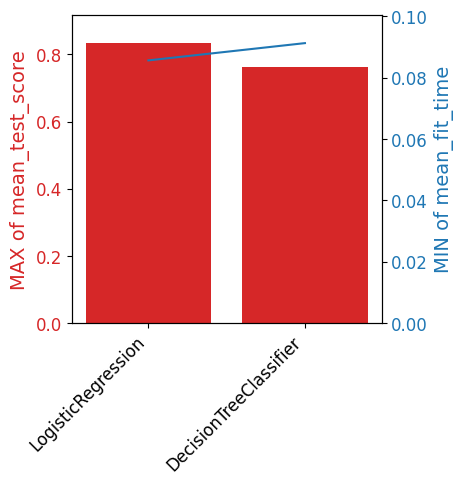

In [39]:
ml.compareEstimatorsInGridSearch(gs4,tableorplot='plot',figsize=(4,4))        

#### Transformerlar için farklı sıralamalar

Farklı alternatifler için birkaç gridsearch çalıştırmak gerekebilir. Örneğin birinde önce feature selection sonra encoding, diğerinde tam tersi gibi. Bu alıştırmayı da size bırakıyorum.

### Kaynaklar

- https://scikit-learn.org/stable/modules/compose.html
- https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html
- https://stackoverflow.com/questions/67858871/pass-arguments-to-functiontransformer-in-pipeline
- https://www.geeksforgeeks.org/prediction-using-columntransformer-onehotencoder-and-pipeline/
- https://www.youtube.com/watch?v=irHhDMbw3xo
- https://towardsdatascience.com/pipeline-columntransformer-and-featureunion-explained-f5491f815f
- https://machinelearningmastery.com/create-custom-data-transforms-for-scikit-learn/

### CUDA ile GPU kullanımı

10b notebook'una bakınız

## Model Evaluation

Şimdi, pipelinımız da oluştuğuna ve en iyi modelimizi seçebilecek durumda olduğumuza göre artık test datası ile tahminleme yapıp modelimizi değerlendirmeye geçebiliriz.

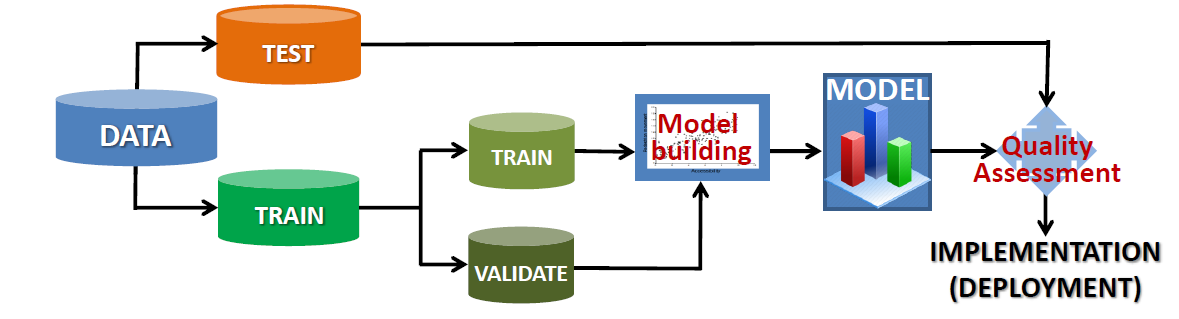

Şimdi burdaki ilk soru şu olabilir, biz zaten train seti üzerinden bir score ölçümü yapmıştık, o değerlendirme değil miydi, daha ne değerlendirmesi yapacağız? Aslında adı üzerinde; bu skor, train setinin skoruydu. Modelimizin generalization(genelleştirilmiş) performansını test setinin skoru verir, traininki değil. 

Test performansı genellikle train setinin performansından biraz daha kötü olacaktır. Bu normal olup, hyperparametrelerle biraz daha oynamaya çalışmanıza gerek yoktur. Bu arada bazen ender olarak test setin performansı traininkinden de iyi çıkabilir. 

Ancak train ve testin skorları arasında normal sayılamayacak büyüklükte fark varsa, modelimizin **overfit** ediyor diyeceğiz ve bu problemi çözmeye çalışacağız. Ama aslında daha öncesinde şuna bakacağız: Train setimizin performansı beklentimizin(veya varsa bir baseline modelin) yeterince üstünde mi? Değilse, bu sefer de modelimiz **underfit** ediyor diyeceğiz ve test setinin ölçümüne hiç geçmeyeceğiz bile. Hadi şimdi bu iki kavrama ve bunların olması durumunda ne tür aksiyonlar alacağımıza bakalım.

### Bias-Variance Tradeoff & Overfitting/Underfitting

Train setimizin eğitimi sonucunda çıkan skor beklediğimizin çok altındaysa(classification için böyle, regressionda ise tam tersi) modelimiz `underfit` ediyor ve `high bias` bir modelimiz var demektir. Neden high bias, çünkü modelimiz onu gerektirdiği varsayımlara karşı önyargılıdır(biased), varsayımları çok basite indirgiyordur. 

Aynı şekilde modelimiz test datasında train datasına göre çok kötü performe ediyorsa `overfit` ediyordur ve `high variance` bir modelimiz vardır deriz, buna high variance denme sebebi de, test seti verdiğimizde çıkan hataların çok dalgalanması, yani yüksek variancelı olmasındandır. Bu isimlendirmeyle alakalı <a href="https://datascience.stackexchange.com/questions/45578/why-underfitting-is-called-high-bias-and-overfitting-is-called-high-variance">şurda</a> güzel bi açıklama mevcut, oraya da bakmanızı tavsiye ederim.

Bias ve variance iki zıt olgudur, biri artarken biri düşer. Amacımız ikisini de düşürmek ama birini düşürürken diğeri arttığı için optimum noktayı bulmaya çalışırız.

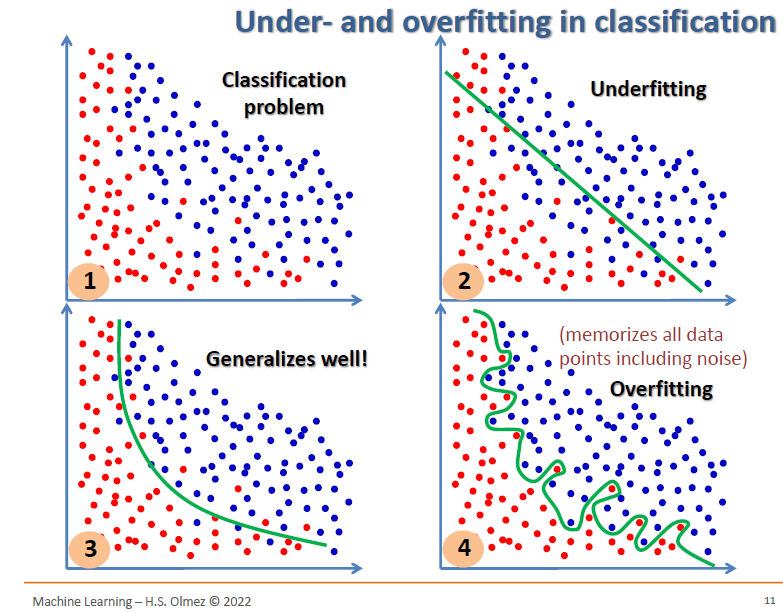

Bir başka yaygın gösterim şöyledir.

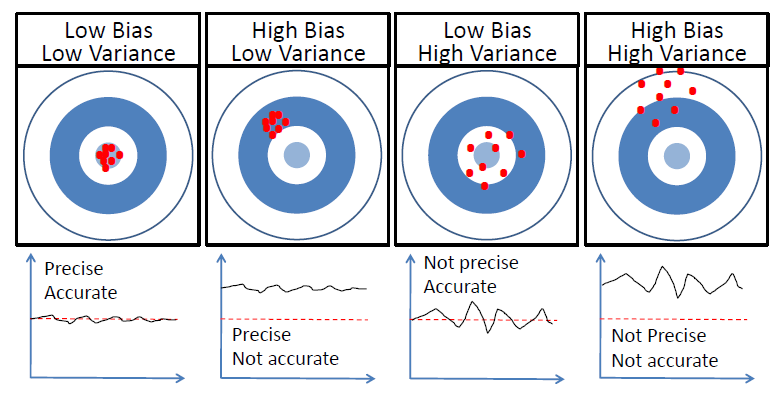

Özetleyecek olursak, bu iki öğrenme sorununun sebepleri ve çözüm önerileri şöyledir:

**Overfitting;**

*Sebepleri:*

-	Model, gürültülü veriyi(hata ve outlierları) ezberlemiştir
-	Elimizde az miktarda data vardır, zaten bir kısmını da teste ayırmışızdır, öğrenilecek data iyice azalmıştır, data en küçük ayrıntısına kadar ezberlenmiştir.
-	Gereksiz karmaşıklıkta bir model kullanmışızdır, halbuki ihtiyaç basit modeldir
-	Çok feature vardır

*Nasıl anlarız:*

-	Train accuracy >> test accuracy

*Çözüm:*

-	Outlier handling -> noise düşürme
-   Hatalı kayıtların temizlenmesi
-	Veri azsa artırılabilir
-	Model basitleştirilebilir
-	Kolon çoksa feature selection ve/veya PCA yapılabilir
-	Linear modelse regularization eklenebilir, tree based bir modelse arama derinlik düşürülebilir
-   Ensemble model kullanılabilir

**Underfitting**

*Sebepleri:*

-	Elimizde az miktarda data vardır, zaten bir kısmını da teste ayırmışızdır, öğrenilecek data iyice azalmıştır, data yeterli gelmemiştir.
-	Karmaşık bir model gerekliyken basit bir model kurmuşuzdur

*Nasıl anlarız:*

-	Eğitim setinin performansı çok düşüktür. Testinkine bakmaya gerek bile olmaz.

*Çözümler:*

-	Daha karmaşık model kullanılabilir
-	Yeni feature eklenebilir
-	Linear modelse regularization miktarını düşürebilir, tree based bir modelse arama derinliğini artırabiliriz.

### Test datası tahmini

Buraya kadar bulduğumuz skorlar, hala model selection aşamasında olduğumuz için train setinin skoruydu. Tekrar hatırlatmak gerekirse gridsearch sonucunda çıkan **best_score_** değeri, cross validation yaparken ayırdığımız validation setlerinin ortalama skorudur. 

Şimdi kısa bir ara verip test datamızı tahminleyelim, sonra farklı ölçüm metrikleriyle ve yöntemleriyle devam edeceğiz.

In [40]:
#öncelikle nolur nolmaz yedeğimizi alalım
X_test_orj=X_test.copy()

#### pipelinsız tahmin

Bu yöntem çok zahmetli olacaktır. X_test üzerinde, train setinde yaptığımız tüm manuel processingleri yapmayı gerektiriyor. Normalde test tahminlemeyi bu şekilde yapmayız, belki bunu sadece eğitim amaçlı kaynaklarda görebilirsiniz. Ama burda yapsaydık şu şekilde yapardık(kodsuz), böylece bunun ne kadar zahmetli olduğunu siz de görün.

- X_test[nums] = numimp.transform(X_test[nums]) diyerek numeriklerin imputationuını yapardık
- aynısını categorikler için yapardık
- sonra outlierhandlingi yapardık
- sonra feature selection yapardık
- sonra nominallerin onehot ecnodingini, chestpain'in ordinal encodingini yapar ve bunlarla diğer ordinal kolonları birleştirirdik, ama burası bizim için biraz daha zahmetli olurdu, zira artık kolon bilgilerini kaybettiğimiz için bunların kolon indekslerini da bulup öyle işleme sokmak zorunda kalırdık
- sonra scaling yapardık
- son olarak da tahminlememizi yapardık

#### pipelinelı tahmin

Pipelinelı bir model kurduğumuzda işlerin ne kadar kolay olduğunu görelim. Yukardaki gridsearchlerden birinin best estimatorünü alıp onunla doğrudan tahminleme yapacağız. Hatta best_estimator_ almaya da gerek yok, çünkü zaten **refit=True** idi, yani şuan **gs4=gs4.best_estimator_**. O kendi içinde tüm transformerları kendi içinde yapıyor olacak.

In [41]:
#generalization performance skoru
gs4.score(X_test,y_test) 

0.8032786885245902

Bu kadar basit. Harika değil mi :)

Train scorumuz 0.83 civarıydı, sanki hafiften bi overfitting var gibi ama şimdi bi learning curve'e bakalım, daha derin yorumlamalarda bulunalım.

#### Learning Curve

Learning curve train seti ile çizdirilir. Amaç, daha fazla veri eklendiğinde cross-validation sonucu iyileşme trendine giriyor mu, onu görmektir. Zira hem overfitting hem underfitting çözümünde ne demiştik; veri miktarı artırılırsa iyileşme bekleriz.

/home/volkan/Documents/Programming/PythonRocks/Tutorials/Veri Bilimi Akademisi/ML/.mlenv/lib64/python3.13/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/volkan/Documents/Programming/PythonRocks/Tutorials/Veri Bilimi Akademisi/ML/.mlenv/lib64/python3.13/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/volkan/Documents/Programming/PythonRocks/Tutorials/Veri Bilimi Akademisi/ML/.mlenv/lib64/python3.13/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/volkan/Documents/Programming/PythonRo

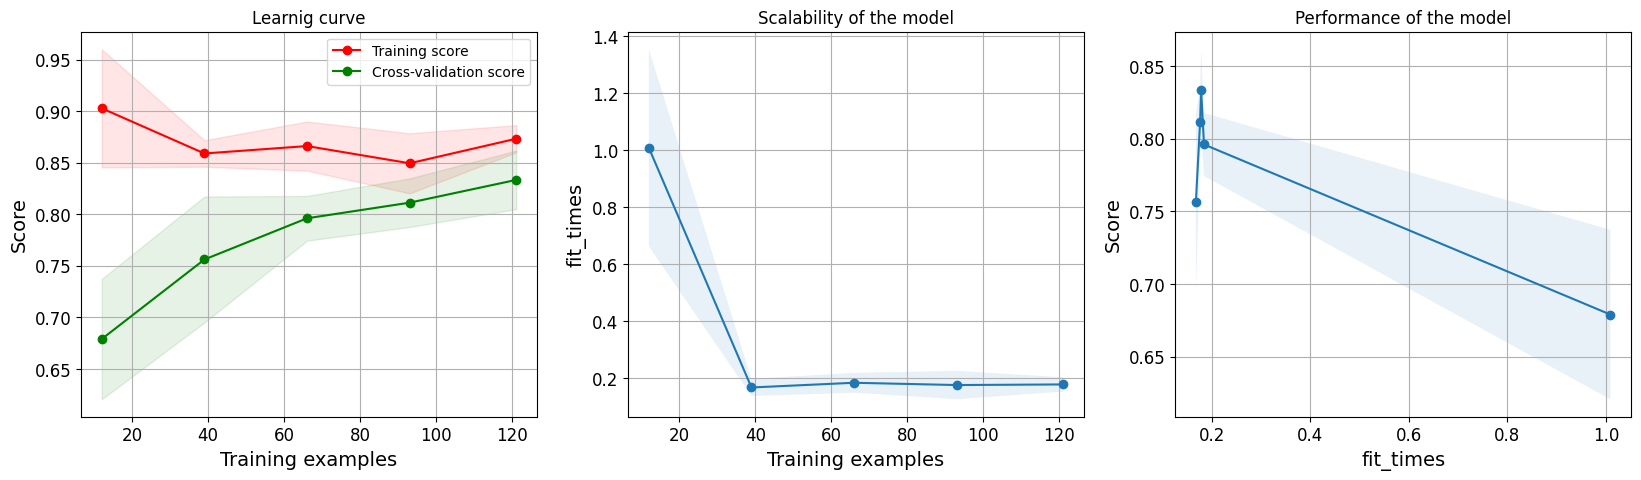

In [42]:
ml.plot_learning_curve(gs4.best_estimator_,"Learnig curve",X_train,y_train,cv=mycv)

Soldaki grafikten analışıyor ki, cv score 80-100 arası platoya ulaşıyor gibi ancak sonrasında tekrar iyileşmeye devam ediyor, yani sample sayısı artarsa sonuç da daha iyi olacak gibi görünüyor.

- https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/
- https://towardsdatascience.com/learning-curve-to-identify-overfitting-underfitting-problems-133177f38df5

### Ölçüm metrikleri

#### Accuracy score

Bu skor, toplam yaptığımız tahmin adedinin ne kadarı doğru(binary classfication için hem 1'ler hem 0'lar) bunu gösterir.   Yukarıda **score** metodu ile yaptığımız işlem bize accuracy'yi döndürdü, çünkü gridsearchü yaparken scoring olarak accuracy seçmiştik. Bununla birlikte sklern.metrics içinde de bu skoru veren bir fonksiyon vardır, ama parametre olarak **y_true**, yani y_test ve tahminlediğimiz labelları yani **y_pred**leri alır. Bu bazen $\bar{y}$ (y_hat) olarak da adlandırılır. Bunun için **predict** metoduyla tahminleme yaparız.

In [43]:
from sklearn.metrics import accuracy_score
y_pred= gs4.predict(X_test) #bazen y_hat
accuracy_score(y_test, y_pred)
y_pred[0],y_test.values[0] #ilk instance için kontrol

0.8032786885245902

('Yes', 'Yes')

Logistic regresyon notebookuna baktıysanız ve işleyişi öğrendiyseniz görmüşsünüzdür ki, aslında bu algoritma bi olasılık hesabı yapıyor, bu hesaplama sonucu %50 üzerindeyse 1(Yes/True), altındaysa 0(No/False) değeri üretiliyor. Peki bu olasılık değerlerini nasıl bulacağız? **predict_proba** metodu ile.

In [44]:
gs4.predict_proba(X_test)[0]

array([0.01681489, 0.98318511])

Mesela burda ilk kayda %98 oranında Yes olur dediği için Yes atanmış olduğunu görüyoruz.

Daha anlaşılır bir şekilde gösterelim.

In [45]:
probs = gs4.predict_proba(X_test)
data = {'Actual'   : y_test,
        'Predicted': gs4.predict(X_test),
        'Prob(No)'  : probs[:,0],
        'Prob(Yes)'  : probs[:,1]  
        }

dfprobs = pd.DataFrame(data)
dfprobs.head(5)

,Actual,Predicted,Prob(No),Prob(Yes)
2,Yes,Yes,0.016815,0.983185
214,Yes,No,0.753673,0.246327
267,Yes,Yes,0.432446,0.567554
61,No,No,0.862771,0.137229
174,Yes,Yes,0.126050,0.873950


Bu arada istersek tahminlerimizi predict ile değil predict_proba'nın sonucuna göre de yapabiliriz. Mesela %50 değil de %80in üzerindekilere Yes diyelim.

In [46]:
np.where(probs[:,1]>0.8,"Yes","No")

array(['Yes', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'Yes', 'Yes',
       'No', 'No', 'Yes', 'No', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Yes',
       'No', 'Yes', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'No', 'Yes', 'No', 'Yes', 'No', 'No', 'No', 'No',
       'No', 'No', 'No', 'Yes', 'No', 'No', 'Yes', 'No', 'Yes', 'No',
       'Yes', 'Yes', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No'],
      dtype='<U3')

Biraz aşağıdaki farklı thresholdlar için sonuçların ne olacağına da bakacağız, ve bunun daha derin bir anlamı olacak.

#### Confusion matrix

Targettaki classlar arasında dengeli bir dağılım varsa, accuracy genelde yeterlidir. Doğru bildiğimiz tahminlerin toplam kayıt sayısına olan oranı verir demiştik. Ancak diyelim ki verisetinizdeki 100bin satırın, 99bini kanserli değil, bini kanserli diye etiketlenmiş olsun. Yani mevcut durumda kansersiz kişi oranı %99. Siz böyle bir durumda hiç model çalıştırmadan tüm kayıtlar için "kanserli değil" tahminini yaptığınızda sözde modelinizin(!) accuracy oranı %99 olacak. Ama bu tahminler gerçekten o kadar başarılı mıdır? Aslında çok başarısız bir tahminleme yönteminiz var, ama bunu nasıl ifade etmek gerekir?

Böyle durumlar için başka metriklere ihtiyaç duyulur. Bunlar için de öncelikle bir `confusion matrix` çıkarılır. Gerçek(Actual) Pozitiflerin(**True positive:TP** de denir), ki bunlara genellikle 1 olarak class etiketi verilir, ve Gerçek Negatiflerin(**True Negative:TN,** etiketi 0) ne kadarını doğru, ne kadarını yanlış tahmin etmişiz, bunu göstermek için idealdir. Genelde aşağıdaki gibi bir tablo ile gösterilirler.

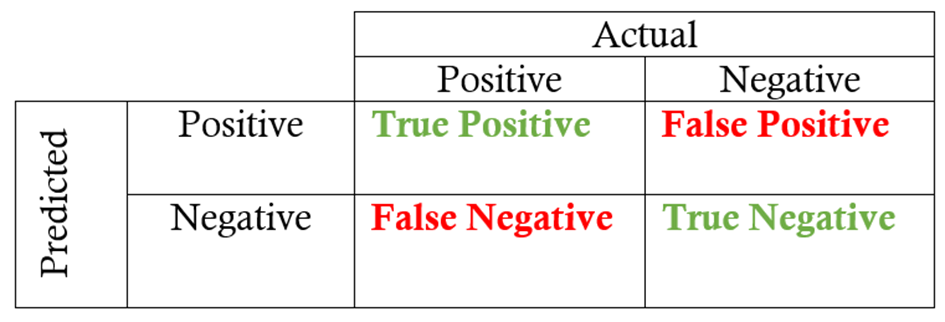

**Not**: Bu gösterim şekli binary classficiation içindir ancak benzer mantıkla 3x3lük matris de bize 3 classlı bir veri seti için confusion matrixi oluşturacak ve ona uygun metrikler de hesaplanabilecektir.

**Uyarı:** Bazen bu tablo transpoze veya köşeler ters olacak şekilde gösterilebilir. Yani aşağıdaki gibi bir tablo da görebilirsiniz. Bu matrix, birçok yerde üstteki gibi gösterilmesine rağmen **sklearn'ün confusion matrix'i** aşağıdaki şekilde oluşur. Bu biraz kafa karıştırıcı ama maalesef durum böyle, bu konuda dikkatli olmanızı tavsiye ederim.

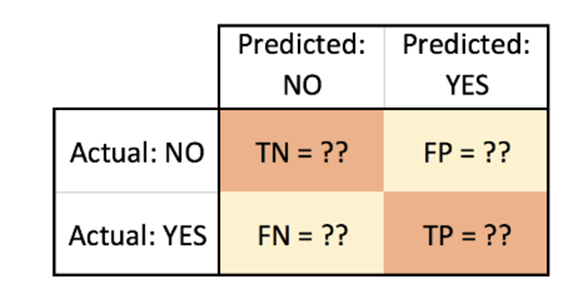

<a href="https://towardsdatascience.com/decoding-the-confusion-matrix-bb4801decbb">Şuradan</a> aldığım şu görsel daha da açıklayıcıdır. Bahsekonu Type I ve II errorları istatistik dünyasından gelmektedir. İlgilenen bunları da araştırabilir.

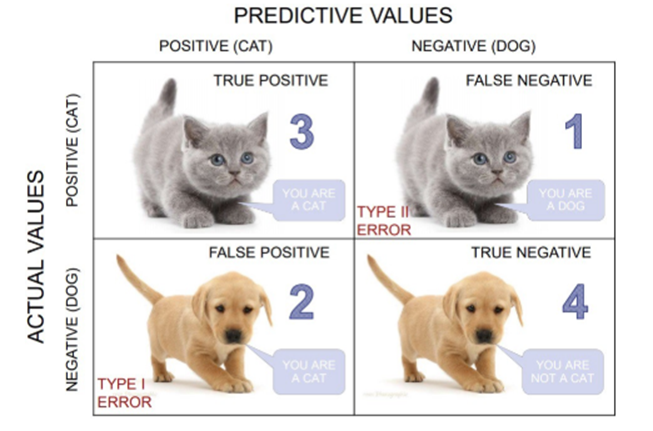

Şimdi sklearn ile bu matrix nasıl çıkarılır, ona bakalım.

In [47]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred)
cm

array([[27,  5],
       [ 7, 22]])

Bunu görsel olarak da ifade edelim.

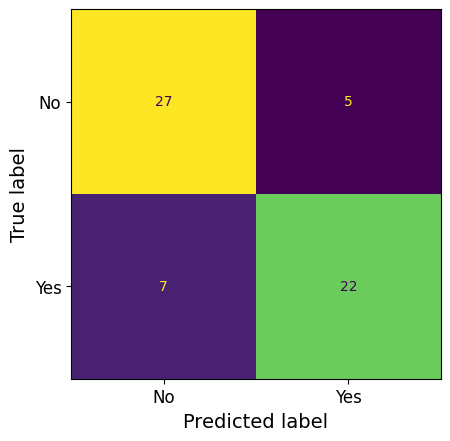

In [48]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(gs4.best_estimator_, X_test, y_test, colorbar=False)
plt.grid(False)

In [49]:
#manuel accuracy hesabı
# (TP+TN)/Toplam
(cm[1,1]+cm[0,0])/np.sum(cm)

np.float64(0.8032786885245902)

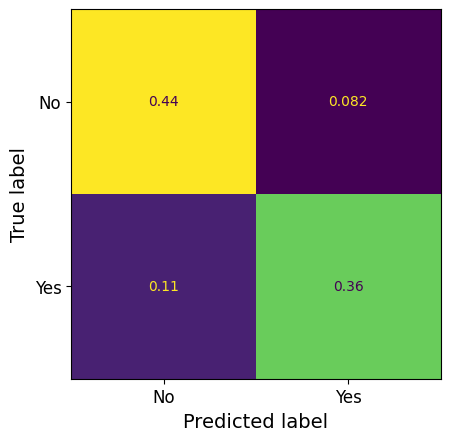

In [50]:
#normalized
ConfusionMatrixDisplay.from_estimator(gs4.best_estimator_, X_test, y_test, colorbar=False, normalize="all")
plt.grid(False);

Şimdi bir de hücrelere label ekleyelim

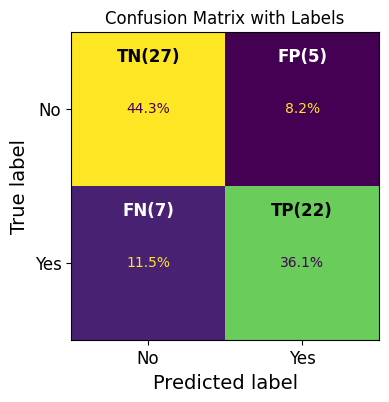

In [51]:
ml.plotConfusionMatrixDisplayWithLabels(gs4.best_estimator_, X_test, y_test)

#### Precision

**TP/(TP+FP)** şeklinde hesaplanır, ki bu aslında **pozitif tahminlerin accuracy'si** olarak da yorumlanabilir. Yani bunda **odak noktası pozitif tahminlerdir**. **Positive Prediction Value** olarak da bilinir. 1'den çıkarılmış haline False Positive Rate denir, ki bunu da ROC/AUC bölümünde göreceğiz.

Bu metrik özellikle imbalanced veri setlerinde anlamlıdır, ama dengeli bir verisetinde de kullanılabilir. Pozitif tahmini yaptığımız zaman hata yapmış olmak çok sıkıntıya neden oluyorsa bu metriği takip etmek önemlidir. Birkaç örneği şöyle sayabiliriz:
- Spam olmayan bir maile(actual=0) spam dersek(prediction=1), önemli bir mailin kaçmasına neden olabiliriz.
- Churn etmeyecek bir müşteriye churn eder dersek, ona gereksiz promosyonlar verilebilir.(Gerçi bunun tersi daha maliyetlidir)
- Kanser olmayan birine kanser teşhisi konması(Tersi durum daha tehlikeli olmakla birlikte, burda da kişinin hayat standartlarını gereksiz düşürebiliriz)

In [52]:
from sklearn.metrics import precision_score
#y'leri labelencode etmediğimiz için pos_label değişkeninde pozitiflerin ne olduğunu belirtiriz
precision_score(y_test,y_pred,pos_label="Yes") 

0.8148148148148148

Pozitif tahminlerimizin %81.5'i doğruymuş.

#### Recall(Sensitivity)

Bu da yine imbalanced datasetlerde çok anlamlıdır. **TP/(TP+FN)** oranıyla hesaplanır ve **gerçekte pozitif olanları tespit edebilme başarısı** olarak düşünülebilir. Yani bundaki **odak noktası pozitif classlardır**. **True Positive Rate(TPR)** olarak da bilinir. Burda da önemli olan gerçekte pozitif (actual=1) olanları doğru tahmin edebilmektir, yani yanlış(false) negatif tanıları minimize etmek isteriz. 

Yukarıda verdiğimiz örneklerden churn ve kanserli örneklerinde bu metrik çok daha önemlidir.

In [53]:
from sklearn.metrics import recall_score
recall_score(y_test,y_pred,pos_label="Yes")

0.7586206896551724

Bu örnek de sağlıkla ilgili bir örnek olduğu için bence şuan en önemli metrik budur. Yani biz her ne kadar accuracy %80miş desek de asıl başarımız %75,8 civarındaymış.

#### Specificity

**True Negative Rate (TNR)** olarak da bilinen bu oran gerçek negatiflerin ne kadar isabetle tahminlendiğini verir. TN/(FP+TN) şeklinde hesaplanır. Formülü Precision'a benzer. TP yerine TN konur. Ancak Precision tahmin bazlı bir metrik iken specificity gerçek değer bazlı bir metriktir.

sklearn içinde bunun için bir metrik yok ancak negatiflerin recall oranı şeklinde hesaplanabilir.

In [54]:
from sklearn.metrics import recall_score
recall_score(y_test,y_pred,pos_label="No")

0.84375

In [55]:
#ya da 
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn+fp)
specificity

np.float64(0.84375)

#### F1 ve F $\beta$ score

Precision ve Recall'dan hangi durumda hangisinin kullanıldığını biliyoruz. Peki emin değilsek? İşte o zaman F1 oranını kullanabiliyoruz, bu oran bu iki skor arasında bi denge kurmaya çalışır. Şöyle bi örnek veriyorlar: 
Polisseniz ve suçluları yakalamak istiyorsanız, yakaladığınız kişinin suçlu olduğundan emin olmak ve mümkün olduğunca çok suçluyu yakalamak istersiniz.

$$f1 = \frac{2 *\text{Precision}*\text{Recall}}{\text{Precision}+\text{Recall}}$$

In [56]:
from sklearn.metrics import f1_score
f1_score(y_test,y_pred,pos_label="Yes")

0.7857142857142857

f1 skoru, precision ve recall'u eşit öneme sahip gibi düşünür, ama siz FN'ler daha maliyetli diye düşünüyorsanız, yani recall daha önemli ise **F-2 skorunu**, FP'ler daha maliyetli diye düşünüyorsanız yani precision daha önemli ise **F-0.5 skorunu** kullanabilirsiniz.

In [57]:
from sklearn.metrics import fbeta_score
fbeta_score(y_test,y_pred,pos_label="Yes",beta=2)

0.7692307692307693

#### classification report

Yukarıdaki metrikleri class/label bazında bir arada gösteren faydalı ve özet bir rapordur.

In [58]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

          No       0.79      0.84      0.82        32
         Yes       0.81      0.76      0.79        29

    accuracy                           0.80        61
   macro avg       0.80      0.80      0.80        61
weighted avg       0.80      0.80      0.80        61



Burda **support**, y_test içinde ilgili class'taki instance sayısını verir. **macro avg**, aritmetik ortalama verirken **weighted avg** ise adı üzerinde instance sayısıyla ağırlıklandırarak ortalama alır. accuracy'nin f1 altında göründüğüne bakmayın, tabloda bi yere oturtmak zorunda oldukları için ayrı bir kolon açmak yerine oraya koymuşlar.

- https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html

#### Precision-Recall Dengesi

Precision ve Recall aynı anda 1 olamıyor. Biri artarken diğeri azalıyor demiştik. Problemin doğasına göre biri sizin için daha önemli olacaktır. Bunun için de positive demek için nasıl bir threshold belirlemek lazım, buna karar vermek gerekiyor.

Thresholdlar özellikle %50 etrafındaki tahminler için önemli. %51'in 1, %49'ın 0 sayıldığı durumlar gibi. Burda ölçmek istediğiniz şeyde pozitif vakaları(spam mail, tümörlü hücre v.s) ne kadar doğru yapmaya heveslisiniz, bunun kararı kritik olmakta. Spam olmayan maile spam demekle, kanserli olmayan kişiye kanserli demek aynı düzeyde hata değildirler. İlkinde çok az hata yapmak istersiniz, aksi halde önemli bir maili kaçırmış olabilirsiniz, ikincisinde ise sağlıklı kişiye kanser dediğiniz için gereksiz yere kanser tedavi masrafları oluşur, belki bir de yan etkiler görülür. Tersten baktığımızda ise spam bir maile spam değil dersek, inboxımızda bu maili görmüş oluruz, bunun da çok yıkıcı etkisi olmaz, bu hata kabul edilebilir. Ama kanserli kişiye "kanserli değil" dersek kişiyi tedaviden mahrum bıraktığımız için ölümüne neden olabiliriz, ki bu çok büyük bir hatadır.

Bu yüzden spam konusunda amacımız tüm pozitif(P) tahminlerimizi doğru(T) bilmiş olmak, yani %100 precision/specifity sağlamak isteriz. TP/(TP+FP). Burda, thresholdumuzun yüksek olmasına isteyeceğiz. Yani %51i spam saymayacağız, belki dieyceğiz ki %90 üzeri olasılık varsa bunu spam say. Varsın, %80 ihtimalle spam olan bir maile spam demeyelim ve inboxımza düşsün, çok da kritik değil.

Kanser örneğinde ise gerçekte pozitif olan tüm caseleri doğru tahminlemek isteriz, yani kanserliye kanser değilsin(False Negative) demek istemeyiz. TP/(TP+FN), yani %100 recall isteriz. Bunun için de %20 bile bir ihtimal olsa buna kanserli diyelim diyeceğiz, varsın bazı sağlıklılara(%30 ihtimalle kanser) "kansersin" diyelim.

Aynı anda ikisinin %100 olmasını bekleyemeyiz dedik, bi denge sağlamaya çalışacağız.

Konuyu pekiştirmek için güncel bir örnek daha verelim(Yıl 2021). Bir kişiye yanlışlıkla "corona pozitif" demek(False positive), çok büyük bi sorun yaratmayacaktır, o kişi gereksiz yere karantinaya alınacak, hayat standardı düşecek, ancak yanlışlıkla "negatifsin" demek(False Negative), salgının artmasına neden olacaktır. O yüzden burdaki pozitiflik thresholdunun çok düşük tutulması gerektiği aşikardır.

##### ROC Curve ve AUC score

Çeşitli thresholdlar için **TPR(y) ve FPR(x)** grafiği çizdiğimizde `ROC(Receiver Operating Characteristic)` eğrisini elde etmiş oluruz. ROC altında kalan alan ise `AUC(Area Under Curve)` metriği olarak karşımıza çıkar ve bu metrik farklı modellerin performanslarını karşılaştırmak için kullanılır. AUC değeri ne kadar büyükse o kadar iyidir.

Optimal threshold bilgisi, farklı thresholdlar için oluşan confusion matrixlerden görülebilir ancak bu kadar çok confusion matrixi yorumlamak zor olmakta, o yüzden ROC gibi görsel bir araç yardımımıza koşmaktadır.

**Önemli:** AUC değeri, positive ve negativelerin sayılarının birbirine yakın olduğu yani **imbalance olmadığı** durumlarda anlamlıdır ve imbalanced bir verisetinde kullanıl**ma**malıdır. Ayrıca true negative ve true positiveler eşit öneme sahipse kullanılmalıdır. Bakınız **Özet ve Karşılaştırma**

Bunun için hazırladığım fonksiyonu aşağıdaki gibi kullanabileceğimiz gibi, aşama aşama neler olduğunu görmek için bu fonksiyonu satır satır da çalıştırabilirsiniz.

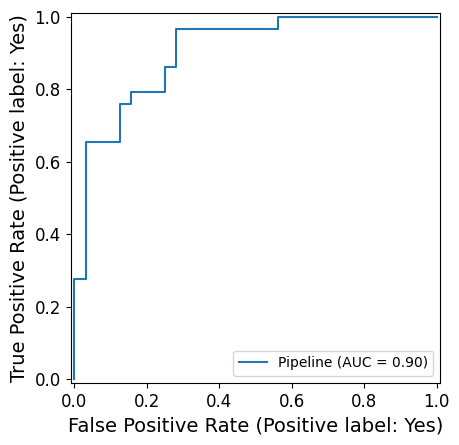

In [59]:
#önce built-in function
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(gs4.best_estimator_, X_test, y_test)
#ya da hazırda hesaplanmış skor varsa
# y_score = gs4.best_estimator_.predict_proba(X_test)[:, 1]
# RocCurveDisplay.from_predictions(y_test, y_score)


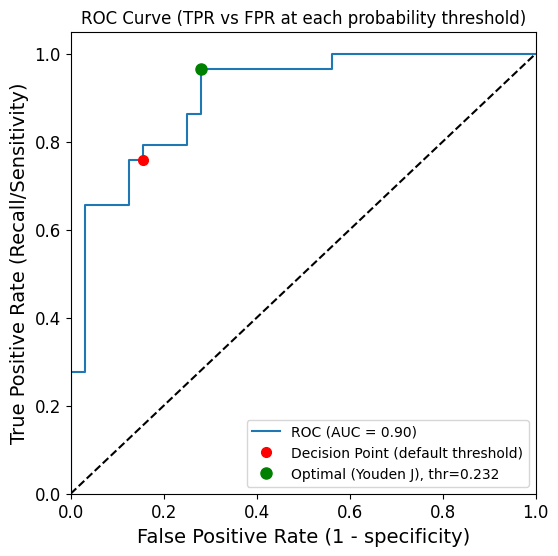

In [60]:
ml.plotROC(y_test, X_test, gs4, pos_label="Yes")

Burdaki decision point için şuan standart thresholddaki(0.5) confusion matrix sonucuna göre TPR-FPR kesişimi gösterilmiştir. Yani 0.5 kullandığımızda değerler TPR ve FPR için sırayla ~0.76 ve ~0.16'dır. Arzu edilen threshold için ilgili nokta bulunabilir.

Burdan çıkan AUC değerini başka bir modelinkiyle de karşılaştırmak faydalı olacaktır. Şimdi mesela bir gridsearchümüzdeki DecisionTree'nin en iyi parametre bilgilerini alıp bakalım.

In [61]:
cvres = gs4.cv_results_
cv_results = pd.DataFrame(cvres)
cv_results["param_clf"]=cv_results["param_clf"].apply(lambda x:str(x).split('(')[0])

dtc=cv_results[cv_results["param_clf"]=="DecisionTreeClassifier"]
dtc.getRowOnAggregation_("mean_test_score","max")["params"].values[0]

{'clf': DecisionTreeClassifier(random_state=42),
 'clf__criterion': 'gini',
 'clf__max_depth': 3,
 'clf__min_samples_split': 2,
 'ct__numerics__ouh': None,
 'ct__numerics__scl': None}

Bu parametreleri aşağıda DecisionTreeClassifier constructorı içine verelim.

In [62]:
cat_pipe=Pipeline([ 
                   ("csi", SimpleImputer(strategy="most_frequent")),
                   ("ohe", OneHotEncoder(drop="first",handle_unknown='ignore'))     
                  ])

num_pipe=Pipeline([  
                   ("nsi", FunctionTransformer(numericImputer))
                  ])

coltrans = ColumnTransformer([
                                ('nominals',  cat_pipe, noms),
                                ('ordinals',  OrdinalEncoder(categories=[['typical', 'asymptomatic', 'nonanginal', 'nontypical']]), ["ChestPain"]) , #direkt burada işleme sokarak
                                ('numerics',  num_pipe, nums)
                                 ],n_jobs=-1,remainder="passthrough")


pipe_dt = Pipeline(steps=[('ct', coltrans),
                       ('fs', SelectKBest(score_func=mutual_info_classif,k=10)), 
                       ('clf', DecisionTreeClassifier(random_state=40,criterion="gini",max_depth=3,min_samples_split=2)) 
                       ])

pipe_dt.fit(X_train,y_train);

In [63]:
pipe_dt.score(X_test,y_test)

0.7704918032786885

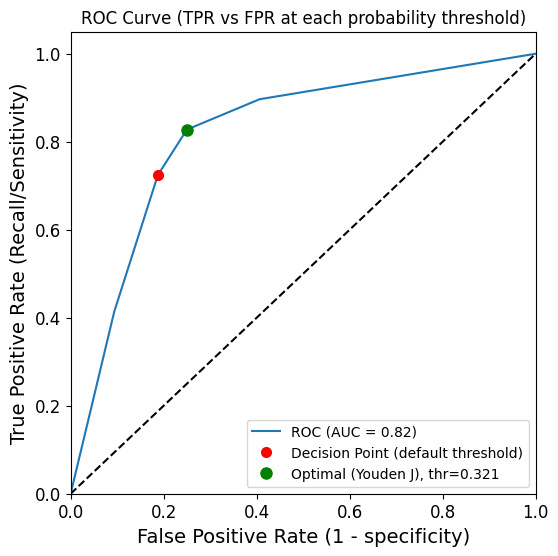

In [64]:
ml.plotROC(y_test, X_test, pipe_dt, pos_label="Yes")

Bunun AUC değeri LogReg'den daha düşük çıktı.

##### Precision-Recall Curve

Imbalanced data sözkonusu olduğunda Precision-Recall curve, ROC-AUC'dan çok daha yararlıdır. Zira, burda farklı modeller arasındaki sonuçlar çok daha çarpıcı olmakta ve model seçimi de daha kolay olmaktadır.

ROC'da Recall ve 1-Precision bakılırken burda Recall ve Precision bakılır.

Burda yine hazır yazılmış bir fonksiyonum var, onu kullanacağız. Fakat bu sefer labellara Yes/No şeklinde değil de 1/0 şeklinde ulaşmak istedim, o yüzden şimdi bunları bi encode edelim.

In [65]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
y_train_le=le.fit_transform(y_train)
y_test_le=le.transform(y_test)
y_test_le[:5]

array([1, 1, 1, 0, 1])

Plotumuzu çizelim

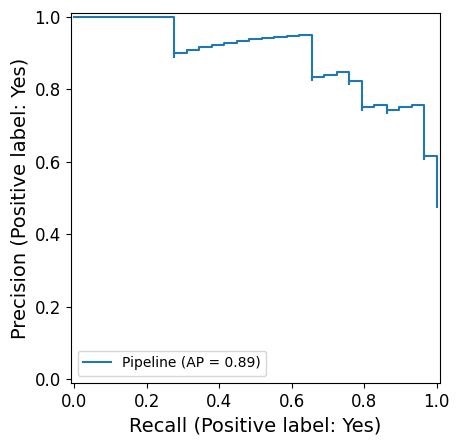

In [66]:
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_estimator(gs4.best_estimator_, X_test, y_test)
#ya da hazırda hesaplanmış skor varsa
# y_score = gs4.best_estimator_.predict_proba(X_test)[:, 1]
# PrecisionRecallDisplay.from_predictions(y_test, y_score, pos_label="Yes")

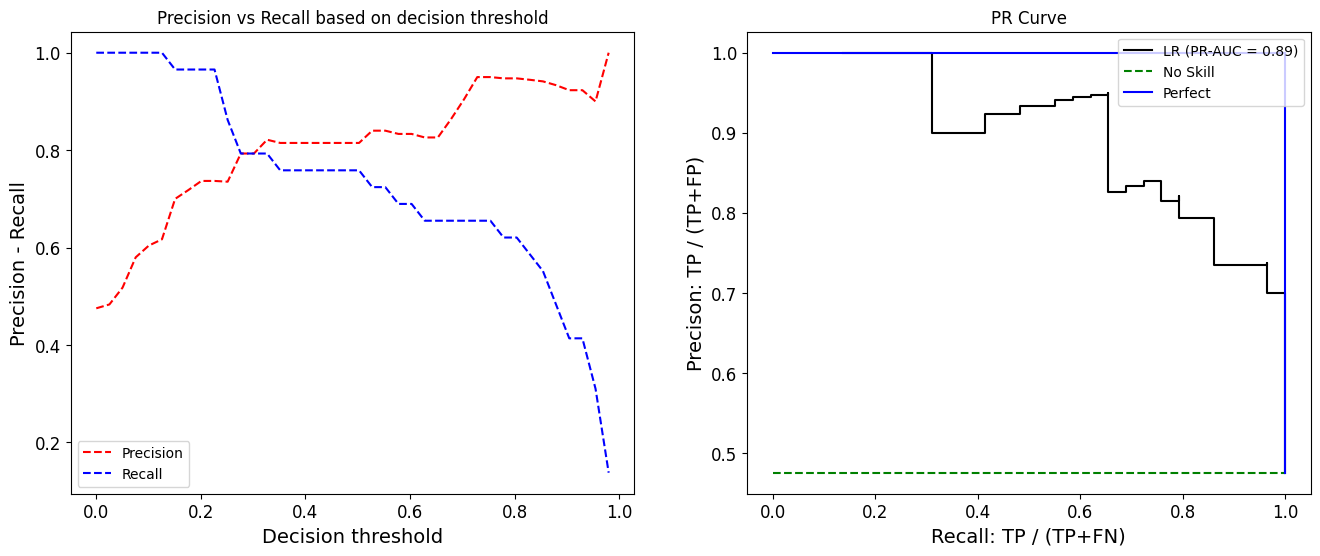

In [67]:
ml.plot_precision_recall_curve(y_test_le,X_test,gs4)

Soldaki grafikte, Precision ve Recall'ün farklı thresholdlar için nasıl bir tradeoff içinde olduğunu görüyoruz. Sağdaki ise Precision-Recall eğrisi olup sağ üst köşeye doğru gittikçe mükemmel bir denge sözkonusu olmaya başlar. Mavi çizgi ideal halken, alttaki yeşil çizgi ise her instance'ın pozitif tahminlendiği, bi beceri gerektirmeyen durumu gösterir.

Son durumda kendimize ideal bir threshold belirledikten sonra nihai tahminlememiz şöyle olacaktır:

In [68]:
from sklearn.preprocessing import binarize
pred_prob = gs4.predict_proba(X_test)    
binarize(pred_prob, threshold=0.4)[:,1]
#veya
np.where(pred_prob[:,1]>0.4,1,0)

array([1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1.,
       0., 1., 1., 0., 0., 0., 1., 1., 0., 0.])

array([1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0])

#### Cohen's Kappa

Bunun da bazı durumlarda faydalı bir metrik olduğu söyleniyor. Ben çok inceleme fırsatı yakalayamadım açıkçası. Detaylarını şu sayfalarda bulabilirsiniz:
- https://towardsdatascience.com/multi-class-metrics-made-simple-the-kappa-score-aka-cohens-kappa-coefficient-bdea137af09c
- https://standardwisdom.com/softwarejournal/2011/12/confusion-matrix-another-single-value-metric-kappa-statistic/
- https://stats.stackexchange.com/questions/82162/cohens-kappa-in-plain-english

Ama <a href="https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0222916 ">şurada</a> ise kaçınılması gerektiği yazıyor. O yüzden çok detaylarına girmiyorum, belki ilerleyen dönemlerde daha derin araştırmalar yaparsam burayı güncellerim.

#### Cumulative Gains ve Lift Charts

Lift ve Gain analizi ile, model olmadan yapacağımız random tahminlere göre modelimizle ne kadar daha iyi **pozitif tahminlemesi** yaptığımızı ölçeriz. Görsel açıdan model performansını ölçmeye yardımcı olan bu analizlerin ikisinde bir baseline vardır, lift eğrisi ile bu baseline arasındaki alan ne kadar büyükse modelimiz o kadar iyi tahmin yapıyor demektir.

Şu aşamalardan oluşur:

- İlk olarak pozitif classtaki tahminlerin olasılık değerlerini alır ve datayı buna göre sıralarız.
- Sonra bunları 10luk dilimlere(Decile) böleriz ve her bir Decile'da gerçek pozitiflerin sayısını buluruz->Number of Responses
- Gain, bu Number of Responses'ların kümülatif değerinin datadaki toplam pozitiflere oranıdır. Yani ilgili decile seviyesinde gerçek pozitiflerin ne kadarını kapsama almışız, onu gösterir. Mesela aşağıdaki tablodan göreceğiniz üzere 5.decile'da gerçek pozitiflerin ~%80ini kapsama almışız. Yani datanın sadece %50siyle bile pozitiflerin %80lik kısmını doğru tahminleyebiliyoruz.
- Lift ise, modelimiz sayesinde random guesse(modelsiz duruma) göre ne kadar iyi pozitif tahminlemesi yaptığımızı gösteriyor. Yine aşağıdaki tabloya baktığımızda 2.seviyede, modelimizin lifti 1.90 olup, datanın %20lik kısmını aldığımızda pozitifleri random seçeceğimiz bir duruma göre 1.90 kat daha doğru tespit edebildiğimizi gösterir, ki bu değer 37.93'ün 20ye oranı oluyor.

,Decile,Number of Cases,Number of Responses,Cumulative Responses,% of Events,Gain,lift
0,1,6,6,6,20.69,20.69,2.07
1,2,6,5,11,17.24,37.93,1.90
2,3,6,6,17,20.69,58.62,1.95
3,4,6,3,20,10.34,68.96,1.72
4,5,6,3,23,10.34,79.30,1.59
5,6,6,4,27,13.79,93.09,1.55
6,7,6,1,28,3.45,96.54,1.38
7,8,6,1,29,3.45,99.99,1.25
8,9,6,0,29,0.00,99.99,1.11
9,10,7,0,29,0.00,99.99,1.00


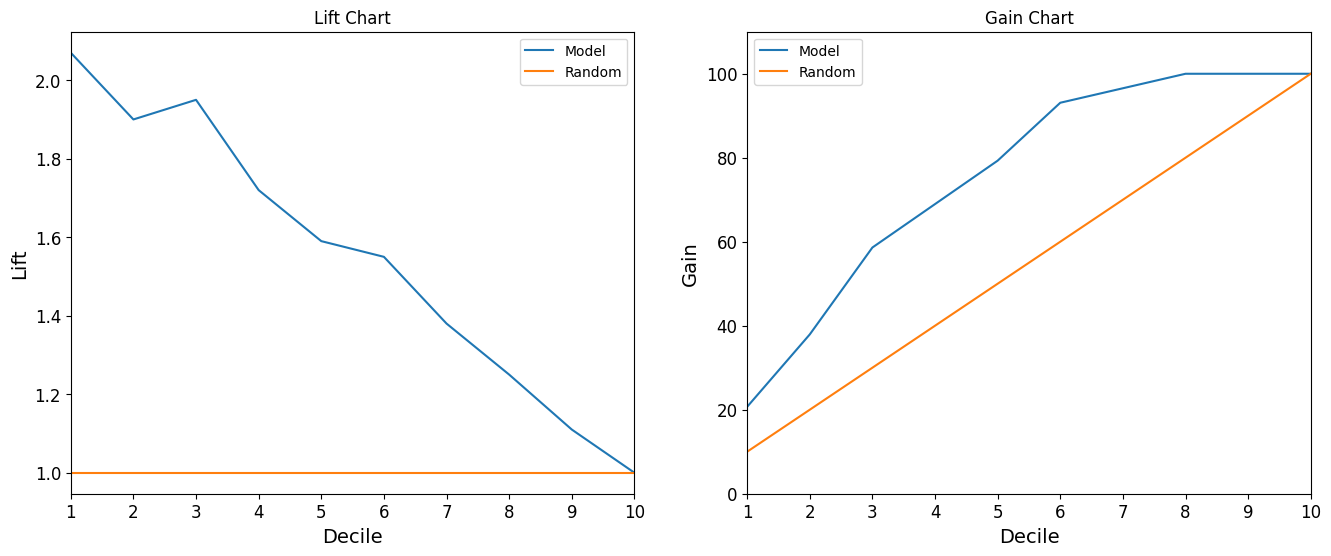

In [69]:
ml.plot_gain_and_lift(gs4,X_test,y_test,pos_label="Yes")    

####  Log loss(logistic loss or cross-entropy loss)

Bu metriğin detaylı açıklamasını <a href="Logistic%20Regression.ipynb">Logistic Regression notebookunda</a> bulabilirsiniz.  Özetle, tahminlenen değerle gerçek değer arasındaki farkın negative logaritmasıdır. Algoritma çalışırken zaten bunu minimize etmeye çalışır.

Bir modelde yapılan gerçek hatayı en iyi gösteren metric olup, modelin genel güvenilirliğini sorgulamak istediğinizde bu metrik kullanılabilir. Aşağıda gördüğünüz üzere gridsearch içinde scoring'e bunun negatif versiyonu(maximize edilsin diye) verilerek bu metric minimize edilmeye çalışılabilir.

In [70]:
gs5 = GridSearchCV(estimator = pipe, param_grid = params, cv = mycv, n_jobs=-1, verbose = 1, scoring = 'neg_log_loss',
                  error_score='raise')

Eğitelim

In [71]:
gs5.fit(X_train, y_train)

Fitting 6 folds for each of 72 candidates, totalling 432 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...Estimator())])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","[{'clf': [LogisticRegre...ndom_state=42)], 'clf__C': [0.001, 0.01, ...], 'clf__l1_ratio': [0], 'clf__solver': ['newton-cg', 'lbfgs'], ...}, {'clf': [DecisionTreeC...ndom_state=42)], 'clf__criterion': ['gini', 'entropy'], 'clf__max_depth': [2, 3], 'clf__min_samples_split': [2, 4], ...}]"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'neg_log_loss'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value 

En iyi skora bakalım

In [72]:
gs5.best_score_

np.float64(-0.4160034067650817)

Sonuçları dataframede görelim

In [73]:
ml.gridsearch_to_df(gs5)

,param_clf,param_clf__C,param_clf__l1_ratio,param_clf__solver,param_ct__numerics__ouh,param_ct__numerics__scl,param_clf__criterion,param_clf__max_depth,param_clf__min_samples_split,mean_test_score,std_test_score
55,"LogisticRegression(max_iter=1000, random_state...",0.5,0.0,lbfgs,None,RobustScaler(),NaN,NaN,NaN,-0.416003,0.033683
51,"LogisticRegression(max_iter=1000, random_state...",0.5,0.0,newton-cg,None,RobustScaler(),NaN,NaN,NaN,-0.416009,0.033680
53,"LogisticRegression(max_iter=1000, random_state...",0.5,0.0,lbfgs,OutlierHandler(featureindices=[1]),RobustScaler(),NaN,NaN,NaN,-0.417993,0.037321
49,"LogisticRegression(max_iter=1000, random_state...",0.5,0.0,newton-cg,OutlierHandler(featureindices=[1]),RobustScaler(),NaN,NaN,NaN,-0.417998,0.037307
47,"LogisticRegression(max_iter=1000, random_state...",0.3,0.0,lbfgs,None,RobustScaler(),NaN,NaN,NaN,-0.418363,0.030164


Bu yeni modeli test seti üzerinden tahminleyip classification reportumuzu çıkaralım.

In [74]:
y_pred= gs5.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

          No       0.79      0.84      0.82        32
         Yes       0.81      0.76      0.79        29

    accuracy                           0.80        61
   macro avg       0.80      0.80      0.80        61
weighted avg       0.80      0.80      0.80        61



Sonuçlar gs4 ile aynı.

Peki bu test setine göre generalization performance'ı ne oluyor, bir de ona bakalım

In [75]:
gs5.score(X_test,y_test)

-0.40185195721936606

Buna şöyle de bakabiliriz, tabi bu sefer pozitif sonuç elde edeceğiz.

In [76]:
from sklearn.metrics import log_loss
log_loss(y_test_le,gs5.predict_proba(X_test))

0.40185195721936606

loss 0.416'dan 0.4018'e düşmüş oldu, normalde test'te loss'un artmasını beklerdik ama küçük bir dalgalanma payı her zaman vardır.

#### Maliyet bazlı modelleme

Şimdi de farklı bir şekilde olaya yaklaşıp, yaptığımız hataların ölçülebilir maliyetleri olsaydı nasıl davranırdık, ona bakalım. Tabi ki hatayı minimize etmeye çalışırdık, şimdi bunları nasıl yapabileceğimizi görelim.

##### Custom Cost function yazma

Daha önce söylediğimiz gibi, iki tür hata vardır ve bunların maliyeti de farklı olabilmektedir. Ör:Spam örneğinde, spam maile "spam değil" demek büyük bir sorun yaratmaz, bu yüzden maliyet 1 olabilir. Ancak spam olmayana spam demek çok büyük sorun yaratabilir, bunun da maliyeti 10 seçilebilir. Buna göre en uygun trehsholdu bularak toplam maliyeti minimize etmek gerekebilir.

Bu bilgiler ışığında kendi modelimiz için çeşitli maliyetler belirlemeye çalışalım. Unutmayın, amacımız, bir hastada kalp hastalığı var mı yok mu onu tahminlemeye çalışıyoruz.

- **Cost of True Negative**: Bunun maliyeti 0'dır.
- **Cost of True Positive**: Bu hastalara ilave tetkikler yapacağız diyelim,  maliyeti 5 olsun. (Ama bi hata yapmadığımız için 0 da diyebilirsiniz isterseniz)
- **Cost of False Negative**: Yanlışlıkla "iyisiniz" diyoruz, halbuki kişi aslında hasta. Ölüm durumu sonunda ailesi tarafından tazminat davası açılabilir. Maliyeti 100 olsun.
- **Cost of False Positive**: Yanlışlıkla hastasın diyoruz. Gerekisiz ilaç veriyoruz, yan etkiler nedeniyle dava açılabilir. Maliyeti 60 olsun.

**Nihai maliyet fonksiyonumuz şöyle**:

$$\text{Cost} = 0.TN + 5.TP + 100.FN + 60.FP$$

Şimdi yine hazır fonksiyonumuzu kullanarak çeşitli thresholdlarda(cutoff) maliyet ve diğer metrikler ne oluyormuş onlara bakalım ve bunların bi grafiğini çizdirelim.

Cutoff	 Cost/Instance	 Accuracy	 FN	 FP	 TP	 TN	 Recall	 Precision F1-score
0.00	 33.85		 0.475		 0	 32	 29	 0	 1.000	 0.475	   0.644
0.05	 27.95		 0.574		 0	 26	 29	 6	 1.000	 0.527	   0.690
0.10	 21.07		 0.689		 0	 19	 29	 13	 1.000	 0.604	   0.753
0.15	 15.74		 0.787		 1	 12	 28	 20	 0.966	 0.700	   0.812
0.21	 13.77		 0.820		 1	 10	 28	 22	 0.966	 0.737	   0.836
0.26	 18.03		 0.787		 5	 8	 24	 24	 0.828	 0.750	   0.787
0.31	 17.62		 0.803		 6	 6	 23	 26	 0.793	 0.793	   0.793
0.36	 18.20		 0.803		 7	 5	 22	 27	 0.759	 0.815	   0.786
0.41	 18.20		 0.803		 7	 5	 22	 27	 0.759	 0.815	   0.786
0.46	 18.20		 0.803		 7	 5	 22	 27	 0.759	 0.815	   0.786
0.52	 18.77		 0.803		 8	 4	 21	 28	 0.724	 0.840	   0.778
0.57	 18.77		 0.803		 8	 4	 21	 28	 0.724	 0.840	   0.778
0.62	 21.89		 0.770		 10	 4	 19	 28	 0.655	 0.826	   0.731
0.67	 21.89		 0.770		 10	 4	 19	 28	 0.655	 0.826	   0.731
0.72	 18.93		 0.820		 10	 1	 19	 31	 0.655	 0.950	   0.776
0.77	 18.93		 0.820		 10	 1	 19	 31	 0.655	 0.95

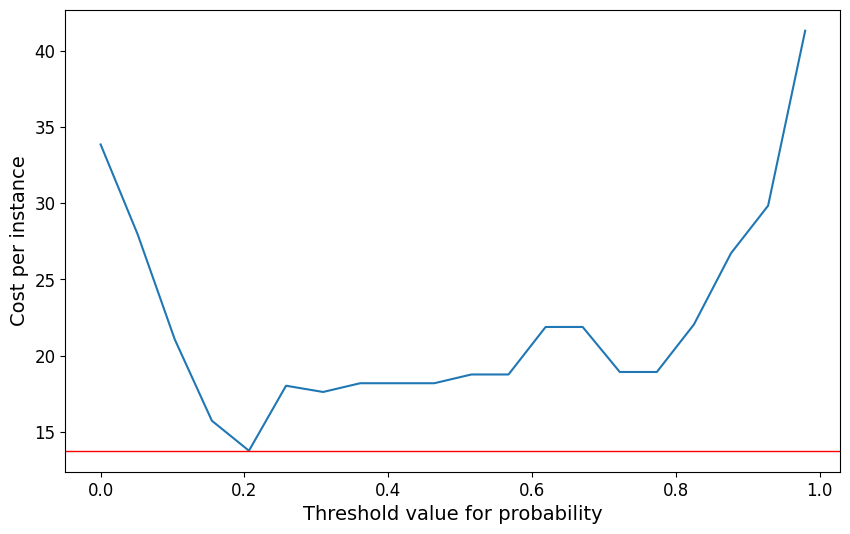

In [77]:
ml.find_best_cutoff_for_classification(gs4, y_test_le, X_test,[0,5,100,60])    

Görüldüğü üzere thresholdun %21 olduğu yerde maliyetimiz en düşük(13.77) oluyor, ki bakarsanız bu aynı zamanda F1 skorunun da en yüksek olduğu yer. Demek ki maliyeti minimize etmek istiyorsak olasılığı default değer olan %50 değil de %21 üstündeki her şeyi pozitif saymalıyız.

Şimdi diyelim ki, hiç model kullanmadık ve ihtiyatlı davranıp herkese hasta dedik, maliyet nolur, bi bakalım. Yani FP hatası yapıyoruz, threshold 0, yani 33.85 birim maliyetimiz olacak. Şimdi de, kimse hasta değil diyelim, yani FN hatası yapalım, böyle bi durumda da maliyetimiz yaklaşık 42 TL olacak.

Her iki durum da modelli yaklaşımımıza göre kötü olacaktır. **Sonuç: Modelimiz oldukça başarılıdır.**

##### Class-weight 

Bazen elimizde böyle maliyet değerleri olmaz, ama dersiniz ki, FN'deki hata FP'deki hatadan şu kadar kat daha önemli, o yüzden FN hatalarını şu kadar kat daha cezalandır.

sklearn bunun için bize `class_weight` adına bir parametre verir. Bu şekilde classlar arasında bi denge yakalamaya çalışırız. Bunun default değeri **None** olup, her iki class(0-1, veya multiclass ise tüm sınıflar) için de eşit ağırlık kullanır, yani 1. Buna ayrıca bir dictionary veya **balanced** değeri de verilebilir. "balanced" verdiğinizde, classların toplam içindeki oranına göre yani prior probabilitysine göre ters mantıkla ağırlıklandırılır, ör: 1000 kaydın 50si "Yes" ise, yani 1'e 20lik bir oran varsa Yes'lerin ağırlığı 20 "No"'ların ağırlığı ise 1 olur.

Burada ayrıca bir **dictionary** verebiliriz dedik,  {0:1, 1:10} şeklinde. Farkettiyseniz bu aynı zamanda bir hyperparametre, dolayısıyla şöyle de tune edilebilir.

<pre>
weights = np.arange(2,21,2)
{'class_weight': [{0:1, 1:x} for x in weights]}
</pre>

In [78]:
weights = np.arange(2,21,2)
{'class_weight': [{0:1, 1:x} for x in weights]}

{'class_weight': [{0: 1, 1: np.int64(2)},
  {0: 1, 1: np.int64(4)},
  {0: 1, 1: np.int64(6)},
  {0: 1, 1: np.int64(8)},
  {0: 1, 1: np.int64(10)},
  {0: 1, 1: np.int64(12)},
  {0: 1, 1: np.int64(14)},
  {0: 1, 1: np.int64(16)},
  {0: 1, 1: np.int64(18)},
  {0: 1, 1: np.int64(20)}]}

class weight'leri atayarak modelimizin cost function'ını da değiştirmiş oluruz. Mesela Logistic Regression için normal log-loss denklemi aşağıdaki gibi olup,

**The log-loss cost function**:

$$\text{Log-loss} = -\sum_{1}^{N}[y_i log(y^*_i)+(1-y_i)log(1-y^*_i)]$$
(Burda, $y_i$ gerçek değerler, $y^*_i$ ise targetın predict_proba değerleridir, N de isntance sayısı)

class weight kullandığımızda şu şekle dönüşür:

**Weighted Log-loss**: $$\text{Log-loss} = -\sum_{1}^{N}[w_0 y_i log(y^*_i)+w_1 (1-y_i)log(1-y^*_i)]$$

Sonra bunları da f-beta skoruyla gridsearch içine sokabilirsiniz.

In [79]:
from sklearn.metrics import fbeta_score, make_scorer

weights = np.arange(2,11,2)
params = [{'clf__C'           : [0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 1],
           'clf__l1_ratio'     : [1], 
           'clf__solver'      : ['liblinear', 'saga'],
           'clf__class_weight': [{"No":1, "Yes":x} for x in weights] + ['balanced']
          },
          
          {'clf__C'           : [0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 1],
           'clf__l1_ratio'     : [0], 
           'clf__solver'      : ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
           'clf__class_weight': [{"No":1, "Yes":x} for x in weights] + ['balanced']
          }
         ]

pipe = Pipeline(steps=[('ct', coltrans),
                       ('fs', SelectKBest(score_func=mutual_info_classif,k=10)), 
                       ('clf', LogisticRegression(max_iter=1000,random_state=42)) 
                       ])

grid_cw = GridSearchCV(pipe, param_grid = params, cv = 3, scoring=make_scorer(fbeta_score, beta=2, pos_label="Yes"), 
                       verbose = 1, n_jobs = -1,error_score="raise")

Eğitelim

In [80]:
grid_cw.fit(X_train, y_train)

Fitting 3 folds for each of 294 candidates, totalling 882 fits


/home/volkan/Documents/Programming/PythonRocks/Tutorials/Veri Bilimi Akademisi/ML/.mlenv/lib64/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/volkan/Documents/Programming/PythonRocks/Tutorials/Veri Bilimi Akademisi/ML/.mlenv/lib64/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/volkan/Documents/Programming/PythonRocks/Tutorials/Veri Bilimi Akademisi/ML/.mlenv/lib64/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/volkan/Documents/Programming/PythonRocks/Tutorials/Veri Bilimi Akademisi/ML/.mlenv/lib64/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","[{'clf__C': [0.001, 0.01, ...], 'clf__class_weight': [{'No': 1, 'Yes': np.int64(2)}, {'No': 1, 'Yes': np.int64(4)}, ...], 'clf__l1_ratio': [1], 'clf__solver': ['liblinear', 'saga']}, {'clf__C': [0.001, 0.01, ...], 'clf__class_weight': [{'No': 1, 'Yes': np.int64(2)}, {'No': 1, 'Yes': np.int64(4)}, ...], 'clf__l1_ratio': [0], 'clf__solver': ['liblinear', 'newton-cg', ...]}]"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",make_scorer(f...pos_label=Yes)
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the

Sonuçları görelim

In [81]:
ml.gridsearch_to_df(grid_cw)

,param_clf__C,param_clf__class_weight,param_clf__l1_ratio,param_clf__solver,mean_test_score,std_test_score
64,0.50,"{'No': 1, 'Yes': 6}",1,liblinear,0.869472,0.012428
66,0.50,"{'No': 1, 'Yes': 8}",1,liblinear,0.868916,0.023961
147,0.05,"{'No': 1, 'Yes': 2}",0,sag,0.867993,0.057863
154,0.05,"{'No': 1, 'Yes': 6}",0,liblinear,0.866597,0.021337
149,0.05,"{'No': 1, 'Yes': 4}",0,liblinear,0.866474,0.024337


In [82]:
#test set başarısı
grid_cw.score(X_test,y_test)

0.8441558441558441

#### Özet ve Karşılaştırma

Birçok metriğimiz oldu. Peki hangisini ne zaman kullanmak gerek?

Ben mümkün olduğunda hangisinin ne zaman kullanmak gerektiğini anlatamaya çalıştım. Bununla birlikte <a href="https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc">burada</a> ve <a href="https://stats.stackexchange.com/questions/210700/how-to-choose-between-roc-auc-and-f1-score">şurada</a> güzel özetler yapılmış, bunlara bakmanızı tavsiye ederim.

#### Kaynaklar

- https://scikit-learn.org/stable/modules/model_evaluation.html
- https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
- https://towardsdatascience.com/the-5-classification-evaluation-metrics-you-must-know-aa97784ff226
- https://towardsdatascience.com/understanding-the-roc-and-auc-curves-a05b68550b69
- https://towardsdatascience.com/model-benefit-evaluation-with-lift-and-gain-analysis-4b69f9288ab3
- https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c
- https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62
- https://medium.com/hugo-ferreiras-blog/confusion-matrix-and-other-metrics-in-machine-learning-894688cb1c0a
- https://medium.com/hiredscore-engineering/7-things-you-should-know-about-roc-auc-b4389ea2b2e3
- https://www.datasciencecentral.com/profiles/blogs/7-important-model-evaluation-error-metrics-everyone-should-know
- https://www.analyticsvidhya.com/blog/2019/08/11-important-model-evaluation-error-metrics/
- https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/
- https://jamesmccaffrey.wordpress.com/2013/11/05/why-you-should-use-cross-entropy-error-instead-of-classification-error-or-mean-squared-error-for-neural-network-classifier-training/
- https://www.data4v.com/understanding-precision-and-recall/
- https://www.youtube.com/watch?v=4jRBRDbJemM
- https://machinelearningmastery.com/cost-sensitive-logistic-regression/
- https://developpaper.com/using-class-weight-to-improve-class-imbalance/
- https://stackoverflow.com/questions/30056331/how-to-list-all-scikit-learn-classifiers-that-support-predict-proba
- https://hunch.net/?p=317
- https://kiwidamien.github.io/are-you-sure-thats-a-probability.html


- https://github.com/DistrictDataLabs/yellowbrick adresinde ise güzel bir paket var, henüz denemedim ama ilk fırsatta deneyeceğim.

### Feature importance

Modelimize en çok hangi featurelar katkıda bulunuyor, yani bunların modeli etkileme gücü ne, bunu ölçebiliyoruz. Bu bilgi DecisionTree/RandomForest/XGBoost gibi modellerin içinde embedded bir şekilde geliyor.(**feature_importance_** propertysi ile). Lineear algoritmalarda da(lineer/logistic regresyon, ridge, lasso, elasticnet gibi) **coefficientlar(katsayılar)** benzer bir görevi görür.(Ama <a href="Linear%20Regression.ipynb">Lineer regresyon notebooknunda</a> görüleceği üzere multicollinearity problemi olmaması lazım, aksi halde bu katsayılar yanıltıcı çıkabilir, her ne kadar modelin tahminleme gücünü etkilemese de)

Diğer algoritmalarda ise **permutation feature importance** diye bir yöntem var, onu kullanabiliyoruz. Bunlara tree-based algoritmalarda geleceğiz.

Biz şimdi elimizdeki model için bakalım.

In [83]:
gs4.best_estimator_["clf"].coef_[0]

array([-0.71717335, -0.66100219,  0.82125279,  0.31450385, -0.70301463,
        0.39399745,  0.98053049,  0.90506928,  1.0166572 ,  0.38544461])

Hazır fonksiyonumuz yardımıyla feature isimlerini de içerecek şekilde grafiğe dökelim.

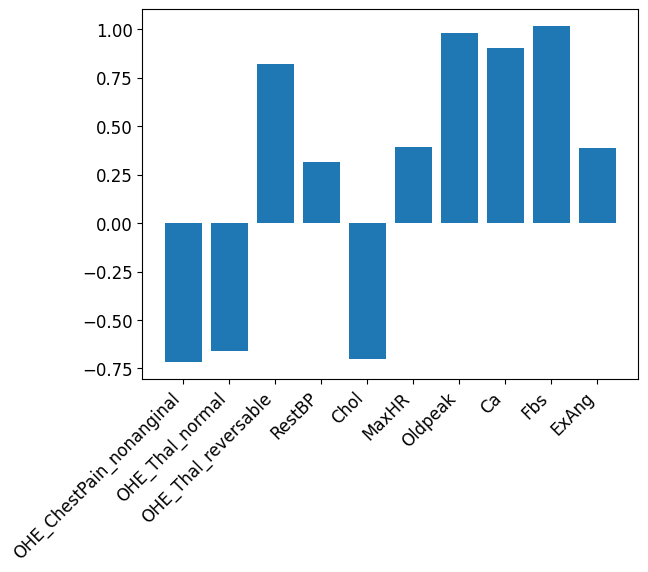

In [84]:
ml.linear_model_feature_importance(gs4,coltrans,"fs","clf")   

Buradaki yorumlama lineer regresyondan biraz farklı olacak, zira elimizde bir class label'ı ve bunun olasılık hesabı var, bunda da logit/sigmoid fonksiyonu kullanılıyor. 

Mesela Ca'daki 1 birim artış logit(p) değerinde 0.90 birimlik artışa denk deriz ama bu tam olarak ne anlama geliyor, buna bakalım. Burda log'un tersini alarak ilerlemek lazım. Yani np.exp(0.90)=2.45, bundan 1 çıkaralım, 1.45, yani Ca'daki 1 birimlik artış kalp hastalığı odds'unda %145'lik bir artışa denk geliyormuş. Binary bir variable olarak Fbs'e bakalım, bunda 1 birim artış lafı anlamsız, bunu 0'dan 1'e çıkmak olarak dile getirelim; 0'dan 1e çıkmak, yani açlık kan şekerinin var olması(1), kalp hastalık odds'unu %174(np.exp(1.01)=2.74-1) artırıyormuş.

Peki odds'un artması ne dmek. Olasılığa nasıl çeviriz? Başlangıç olasıklarını kullanarak. Bunu da aşağıda bir fonksiyon aracılığı ile yapacağız.

<a href="https://towardsdatascience.com/a-simple-interpretation-of-logistic-regression-coefficients-e3a40a62e8cf">Şurada</a> ve <a href="https://quantifyinghealth.com/interpret-logistic-regression-coefficients/">şurada</a> Logistic Regression katsayılarıyla ilgili daha açıklayıcı bir bilgi bulabilirsiniz.

In [85]:
np.exp(0.90), np.exp(1.01)

(np.float64(2.45960311115695), np.float64(2.7456010150169163))

In [86]:
#önce FBS=1 olanların yüzdesine bakalım
X["Fbs"].value_counts(normalize=True)

Fbs
0    0.851485
1    0.148515
Name: proportion, dtype: float64

In [87]:
# odds'un olasılığa etkisi başlangıç olasılığı(prior probability) bağlı
def p_after(p0, coef):
    odds = p0/(1-p0)
    odds2 = odds * np.exp(coef)
    return odds2/(1+odds2)

p_after(0.15, 1.01)

np.float64(0.32638060495804716)

Soru: FBS'in korelasyonu Part I'de düşük çıkmıştı ama katsayısı yüksek çıktı. Bunu nasıl açıklarsınız?

## Interpretability ve Explainabilty

Feature importance ile yakından ilişkili bir konu da modelin yorumlanabilirliği ve açıklanabilirliğidir. Aslında bunlarla karıştırma ihtimali olan bir de fature selection konusu var. Şimdi üçünü birden kısaca bi karşılaştıralım.

- **Feature selection**, "modele en çok hangi featurelar katkıda bulunur?" sorusunu model oluşturmadan önce(filter ve wrapper yöntemler) veya model oluşturma sırasında(RFE veya embedded yöntemlerde olduğu gibi) belirlemeye çalışır.
- **Feature importance** ise model oluştuktan sonra bir featureun model için ne kadar önemli olduğunu söyler.
- **Interpretability/Explainability** konuları ise, belirli bir instance için neden o karar çıktı, onu gösterir. Ör: Bir müşteriye neden kredi çıkmadı, hangi özellikleri nedeniyle. Mesela finansal bir modelde en yüksek öneme sahip olan feature "mevcut borç miktarı" olsun. Bu ne kadar yüksekse kredi alma ihtimali o kadar düşüyor. Ama bi müşteriye, hiç borcu olmadığı halde kredi çıkmamış olabilir. Bunun nedenini bu iki kavram bize sağlamaya çalışır.

Interpretability ve Explainabiltiy arasında da bazı farklar olmakla birlikte, özetle ilki, Desicison treelerde if'li söylemlerle ifade etmek veya lineer modellerde coefficintların önem derecesiyle "dile getirilebilirken", ikincisi o kadar kolay değildir ve ekstra yöntemlere ihtiyaç duyar, DeepLearning modellerinde olduğu gibi. İlk kavram white-box modeller için geçerliyken ikincisi black-box modeller için geçerlidir. Bu ikisi arasındaki farklar için kaynaklardaki ilk 3 linke bakmanızı öneririm.

Şunu da söylemek gerekir ki, modelin performansı ile interpretability'si arasında bir trade-off vardır. Modelin karmaşıklığı ve yorumlanabilirliği azaldıkça başarısı da artar, ve tersi de doğrudur. Şimdi şunu düşünebilirsiniz, "O zaman tüm kurumlar en kompleks, en black-box modelleri kullanıyordur". Cevap hayır, çünkü mesela BDDK gibi regulatif kurumlar bankaların açıklanabilir modeller kullanmasını ister, buna zorlar. Ör:Bir müşteriye neden kredi vermediğini açıklayabilmesini ister.

Bununla birlikte, bu bölümde göreceğimiz gibi `SHAP` ve `LIME` gibi toollar aracılığı ile modellerin açıklanabilirliği çok iyi şekilde yapılabilmektedir. Bunlar, satır bazında açıklanabilirlik veren yaklaşımlar olduğu için çok kıymetlidirler. Ama buna rağmen regulatif kurumlar neden hala white-box modellerde ısrar ederler, bu konuda bir fikrim yok açıkçası.

Biz burada sadece Shap'den bahsedeceğiz. Lime ve başka tool'ları araştırmayı size bırakıyorum. Kaynaklarda bunlarla ilgili linkleri bulabilirsiniz. 

**EDIT:** Bu konuyu şimdilik buraya değil de <a href="Ensemble_RandomForest.ipynb">RandomForest notebook'una</a> almaya karar verdim. Siz yine de önden bakmak isterseniz diye kaynakları bırakıyorum. İleriki bir zamanda elimizdeki model için de buraya SHAP yaklaşımını koymaya çalışacağım.

### Kaynaklar

*Interpretability vs Explainabilty*
- https://towardsdatascience.com/interperable-vs-explainable-machine-learning-1fa525e12f48
- https://www.bmc.com/blogs/machine-learning-interpretability-vs-explainability
- https://www.kdnuggets.com/2018/12/machine-learning-explainability-interpretability-ai.html

*General concept*
- https://christophm.github.io/interpretable-ml-book/ (çok kapsamlı)
- https://medium.com/walmartlabs/interpretable-machine-learning-part-i-bd1829b42b3a
- https://towardsdatascience.com/interpretable-machine-learning-1dec0f2f3e6b
- https://www.kdnuggets.com/2019/05/interpretability-machine-learning-models.html
- https://www.stat.berkeley.edu/~aldous/157/Papers/shmueli.pdf
- https://towardsdatascience.com/human-interpretable-machine-learning-part-1-the-need-and-importance-of-model-interpretation-2ed758f5f476
- https://towardsdatascience.com/three-model-explanability-methods-every-data-scientist-should-know-c332bdfd8df
- https://medium.com/analytics-vidhya/an-explanation-for-explainable-ai-xai-d56ae3dacd13

*SHAP*
- https://github.com/slundberg/shap
- https://towardsdatascience.com/how-to-explain-black-box-models-with-shap-the-ultimate-guide-539c152d3275
- https://towardsdatascience.com/black-box-models-are-actually-more-explainable-than-a-logistic-regression-f263c22795d
- https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27
- https://medium.com/swlh/push-the-limits-of-explainability-an-ultimate-guide-to-shap-library-a110af566a02
- https://towardsdatascience.com/you-are-underutilizing-shap-values-feature-groups-and-correlations-8df1b136e2c2
- https://towardsdatascience.com/shap-shapley-additive-explanations-5a2a271ed9c3
- https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d
- https://towardsdatascience.com/four-custom-shap-plots-8605d73b4570
- https://www.kaggle.com/code/dansbecker/shap-values

*LIME ve diğerleri*
- https://medium.com/analytics-vidhya/explain-your-model-with-lime-5a1a5867b423
- https://towardsdatascience.com/idea-behind-lime-and-shap-b603d35d34eb
- https://medium.com/analytics-vidhya/explain-your-model-with-microsofts-interpretml-5daab1d693b4
- https://towardsdatascience.com/python-libraries-for-interpretable-machine-learning-c476a08ed2c7
- https://towardsdatascience.com/interpretml-analysis-of-svm-and-xgboost-models-e68062f7299f

## Deployment

### Tüm verisetiyle Final Model eğitimi

Hyperparametrelerimizi tune ettikten sonra nihai modelimize karar vermiş olduk. Şimdi bu modeli tüm verisetiyle, yani daha fazla miktarda data ile eğiterek öğrenim gücünü artırmaya çalışalım ve bu haliyle, ilave teste tabi tutmadan deploy edelim.

In [88]:
#en iyi parametre kombinasyonuna tekrar bakalım
gs4.best_params_

{'clf': LogisticRegression(max_iter=1000, random_state=42),
 'clf__C': 0.5,
 'clf__l1_ratio': 0,
 'clf__solver': 'newton-cg',
 'ct__numerics__ouh': None,
 'ct__numerics__scl': RobustScaler()}

En iyi parametre setiyle yeni bir model objesi yaratalım.

In [89]:
finalmodel=LogisticRegression(C=0.2, max_iter=1000, random_state=42, solver='newton-cg' ,penalty="l2")

In [90]:
#pickle hatası almamak için custom fonksiyon ve classımızı ayrı bir dosyaya(custom_func_and_classes.py) koyduk
#custom fonksiyon/class'ınız yoksa buna gerek yoktur
from custom_func_and_classes import numericImputer, OutlierHandler

cat_pipe=Pipeline([ 
                   ("csi", SimpleImputer(strategy="most_frequent")),
                   ("ohe", OneHotEncoder(drop="first",handle_unknown='ignore'))     
                  ])

num_pipe=Pipeline([  
                   ("nsi", FunctionTransformer(numericImputer)), 
                   ("ouh", OutlierHandler(featureindices=[1])), 
                   ("scl", RobustScaler())
                  ])

coltrans = ColumnTransformer([
                                ('nominals',  cat_pipe, noms),
                                ('ordinals',  OrdinalEncoder(categories=[['typical', 'asymptomatic', 'nonanginal', 'nontypical']]), ["ChestPain"]),
                                ('numerics',  num_pipe, nums)
                                 ],n_jobs=-1,remainder="passthrough")

finalpipe = Pipeline(steps=[('ct', coltrans),
                       ('fs', SelectKBest(score_func=mutual_info_classif,k=10)), 
                       ('clf', finalmodel) 
                       ])

Şimdi modelimizi tüm data ile eğitelim.

In [91]:
finalpipe.fit(X,y)

/home/volkan/Documents/Programming/PythonRocks/Tutorials/Veri Bilimi Akademisi/ML/.mlenv/lib64/python3.13/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('ct', ...), ('fs', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('nominals', ...), ('ordinals', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'passthrough'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different t

### Local'e Kaydetme ve Yükleme(Çağırma)

#### Pickle yöntemi

Mevcut **pickle** modülü yerine bunun sklearn replacementı olan **joblib**'teki dump ve load fonksiyonlarını kullanacağız.

In [92]:
#sadece modeli kaydetme
from joblib import dump, load
dump(finalmodel, 'finalmodel.pkl')

['finalmodel.pkl']

Ama bizim modeli değil pipeline'ı kaydetmemiz lazım, zira production ortamında bu pipeline'ı çağıracağız, tüm preprocessingler yapılsın diye.

In [93]:
dump(finalpipe, 'finalpipe.pkl')

['finalpipe.pkl']

In [94]:
#geri yüklemek için
loaded_model = load('finalpipe.pkl') 

Şimdi de yeni bir input verip bunu tahminleyelim. Ama önce inputun shape'i nasıl olmalı, ona bakalım.

In [95]:
X_test.iloc[[0],:].shape #olması gereken input shape böyle
X_test.iloc[0,:].shape #bu değil

(1, 13)

(13,)

Sahadan yeni gelen bir veriyi temsilen X_test'teki ilk satırın aynısını alalım.

In [96]:
loaded_model.predict(X_test.iloc[[0],:]) 

array(['Yes'], dtype=object)

#### Pickling alternatifleri

<a href="https://faoel.medium.com/stop-using-pickle-to-save-machine-learning-models-eaa46e8e561a">Şurada</a> belirtildiği gibi pickle yönteminin bazı dezavantajları var. Ona alternatif olarak şu yöntemlerle locale kaydetme yapılabilir.

- json tercih edilebilir
- keras(veya tensorflow) kullanıyorsak, bunun kendi save metodu kullanılabilir
- pmml kullanmak tercih edilebilir

### Web Deployment

Modelleri locale kaydedip sahadan gelen gerçek verileri localde yaptığımız gibi sonra tekrar load ederek tahminleme yapmak çok amatörce olacaktır. Bunun için kurumunuzun yazılım ekipleriyle görüşüp modelinizin production ortamına alınması gerekecektir. Biz burada bu kadar profesyonel bir iş yapmayacağız ama onun yerine daha orta seviyede bir iş yapıp, projemizi web ortamında nasıl çalıştırırız, ona bakacağız.

Böylece, yaptığınız bir projeyi başkalarıyla(belki de iş görüşmesi yaptığınız kişilerle) paylaşma imkanınız da olacaktır.

**NOT**:<br>
Bu kısım biraz daha programcı ve veri mühendisliği yeteneklerini gerektiriyor. O yüzden isterseniz şimdilik es geçin, ML konusunda kendinizi geliştirdikten sonra tekrar ziyaret edin. Ben de şuan bu kısma çok eğilmemeye karar verdim, sadece birkaç kaynak koyacağım, ilerleyen dönemlerde burayı açıklama ve kod örnekleriyle zenginleştirmeye çalışacağım.

#### Flask ile deployment

- https://towardsdatascience.com/model-deployment-using-flask-c5dcbb6499c9
- https://towardsdatascience.com/lets-deploy-a-machine-learning-model-be6057f2d304
- https://towardsdatascience.com/deploying-models-to-flask-fb62155ca2c4
- https://medium.com/analytics-vidhya/deploying-a-machine-learning-model-on-web-using-flask-and-python-54b86c44e14a
- https://towardsdatascience.com/deploy-a-machine-learning-model-using-flask-da580f84e60c
- https://towardsdatascience.com/deploying-a-machine-learning-model-as-a-rest-api-4a03b865c166

#### Streamlit ile deployment

- https://towardsdatascience.com/how-to-deploy-machine-learning-models-601f8c13ff45
- https://www.datacamp.com/tutorial/streamlit
- https://towardsdatascience.com/streamlit-hands-on-from-zero-to-your-first-awesome-web-app-2c28f9f4e214
- https://towardsdatascience.com/how-to-deploy-machine-learning-models-601f8c13ff45

### Docker Container ile deployment

- https://blog.dataminded.com/from-notebook-hell-to-container-heaven-20cbe05100a1
- https://towardsdatascience.com/the-nice-way-to-deploy-an-ml-model-using-docker-91995f072fe8
- https://medium.com/analytics-vidhya/deploying-machine-learning-model-on-the-top-of-docker-container-ce2c1234a551
- https://towardsdatascience.com/build-and-run-a-docker-container-for-your-machine-learning-model-60209c2d7a7f

### Exe dosyası yaratma

Bir diğer alternatif de projenizi webde değil de masaüstü bir program olarak çalıştırmak olabilir.

- https://python.plainenglish.io/convert-a-python-project-to-an-executable-exe-file-175080da4485
- https://towardsdatascience.com/how-to-easily-convert-a-python-script-to-an-executable-file-exe-4966e253c7e9

### Kaynaklar

*Genel Concepts*
- https://stackoverflow.blog/2020/10/12/how-to-put-machine-learning-models-into-production/
- https://towardsdatascience.com/3-ways-to-deploy-machine-learning-models-in-production-cdba15b00e
- https://machinelearningmastery.com/deploy-machine-learning-model-to-production/
- https://anu-ganesan.medium.com/mlops-in-2021-the-pillar-for-seamless-machine-learning-lifecycle-3a12300d7785
- https://towardsdatascience.com/from-jupyter-notebooks-to-real-life-mlops-9f590a7b5faa

*3rd party webs/apps*
- https://www.kdnuggets.com/2021/04/deploy-machine-learning-models-to-web.html
- https://www.freecodecamp.org/news/deploy-your-machine-learning-models-for-free/
- https://towardsdatascience.com/there-are-two-very-different-ways-to-deploy-ml-models-heres-both-ce2e97c7b9b1
- https://towardsdatascience.com/simple-deployment-of-web-app-ml-model-apis-tutorial-2ece8e66d98c

*Deploying on other environments(ör:asp.net)*
- https://www.activestate.com/blog/how-deploy-machine-learning-models-net-environment
- https://towardsdatascience.com/deploy-sci-kit-learn-models-in-net-core-applications-90e24e572f64

# Faydalı Kaynaklar

## Kitaplar

- Hands-On-Machine-Learning-with-Scikit-Learn-Keras-and-Tensorflow (Aurelien Geron)
- The Elements of Statistical Learning (Trevor Hastie, Robert Tibshirani, Jerome Friedman)
- An Introduction to Statistical Learning (Gareth James, Daniela Witten, Trevor Hastie, Robert Tibshirani)

## Online

- https://scikit-learn.org/stable/
- https://ml-cheatsheet.readthedocs.io/en/latest/index.html
- https://machinelearningmastery.com/
- https://hdsr.mitpress.mit.edu/
- https://data-flair.training/blogs/
- https://www.machinelearningplus.com/
- https://www.geeksforgeeks.org/machine-learning/
- https://developers.google.com/machine-learning/crash-course
- https://www.tensorflow.org/resources/learn-ml